In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

#### Code 5.1

In [3]:
# load data
d = pd.read_csv("Data/WaffleDivorce.csv", sep=";")
# standardize predictor
d["MedianAgeMarriage_s"] = (
    d.MedianAgeMarriage - d.MedianAgeMarriage.mean()
) / d.MedianAgeMarriage.std()

In [4]:
with pm.Model() as model_5_1:
    a = pm.Normal("a", mu=10, sd=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic("mu", a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1859.12draws/s]


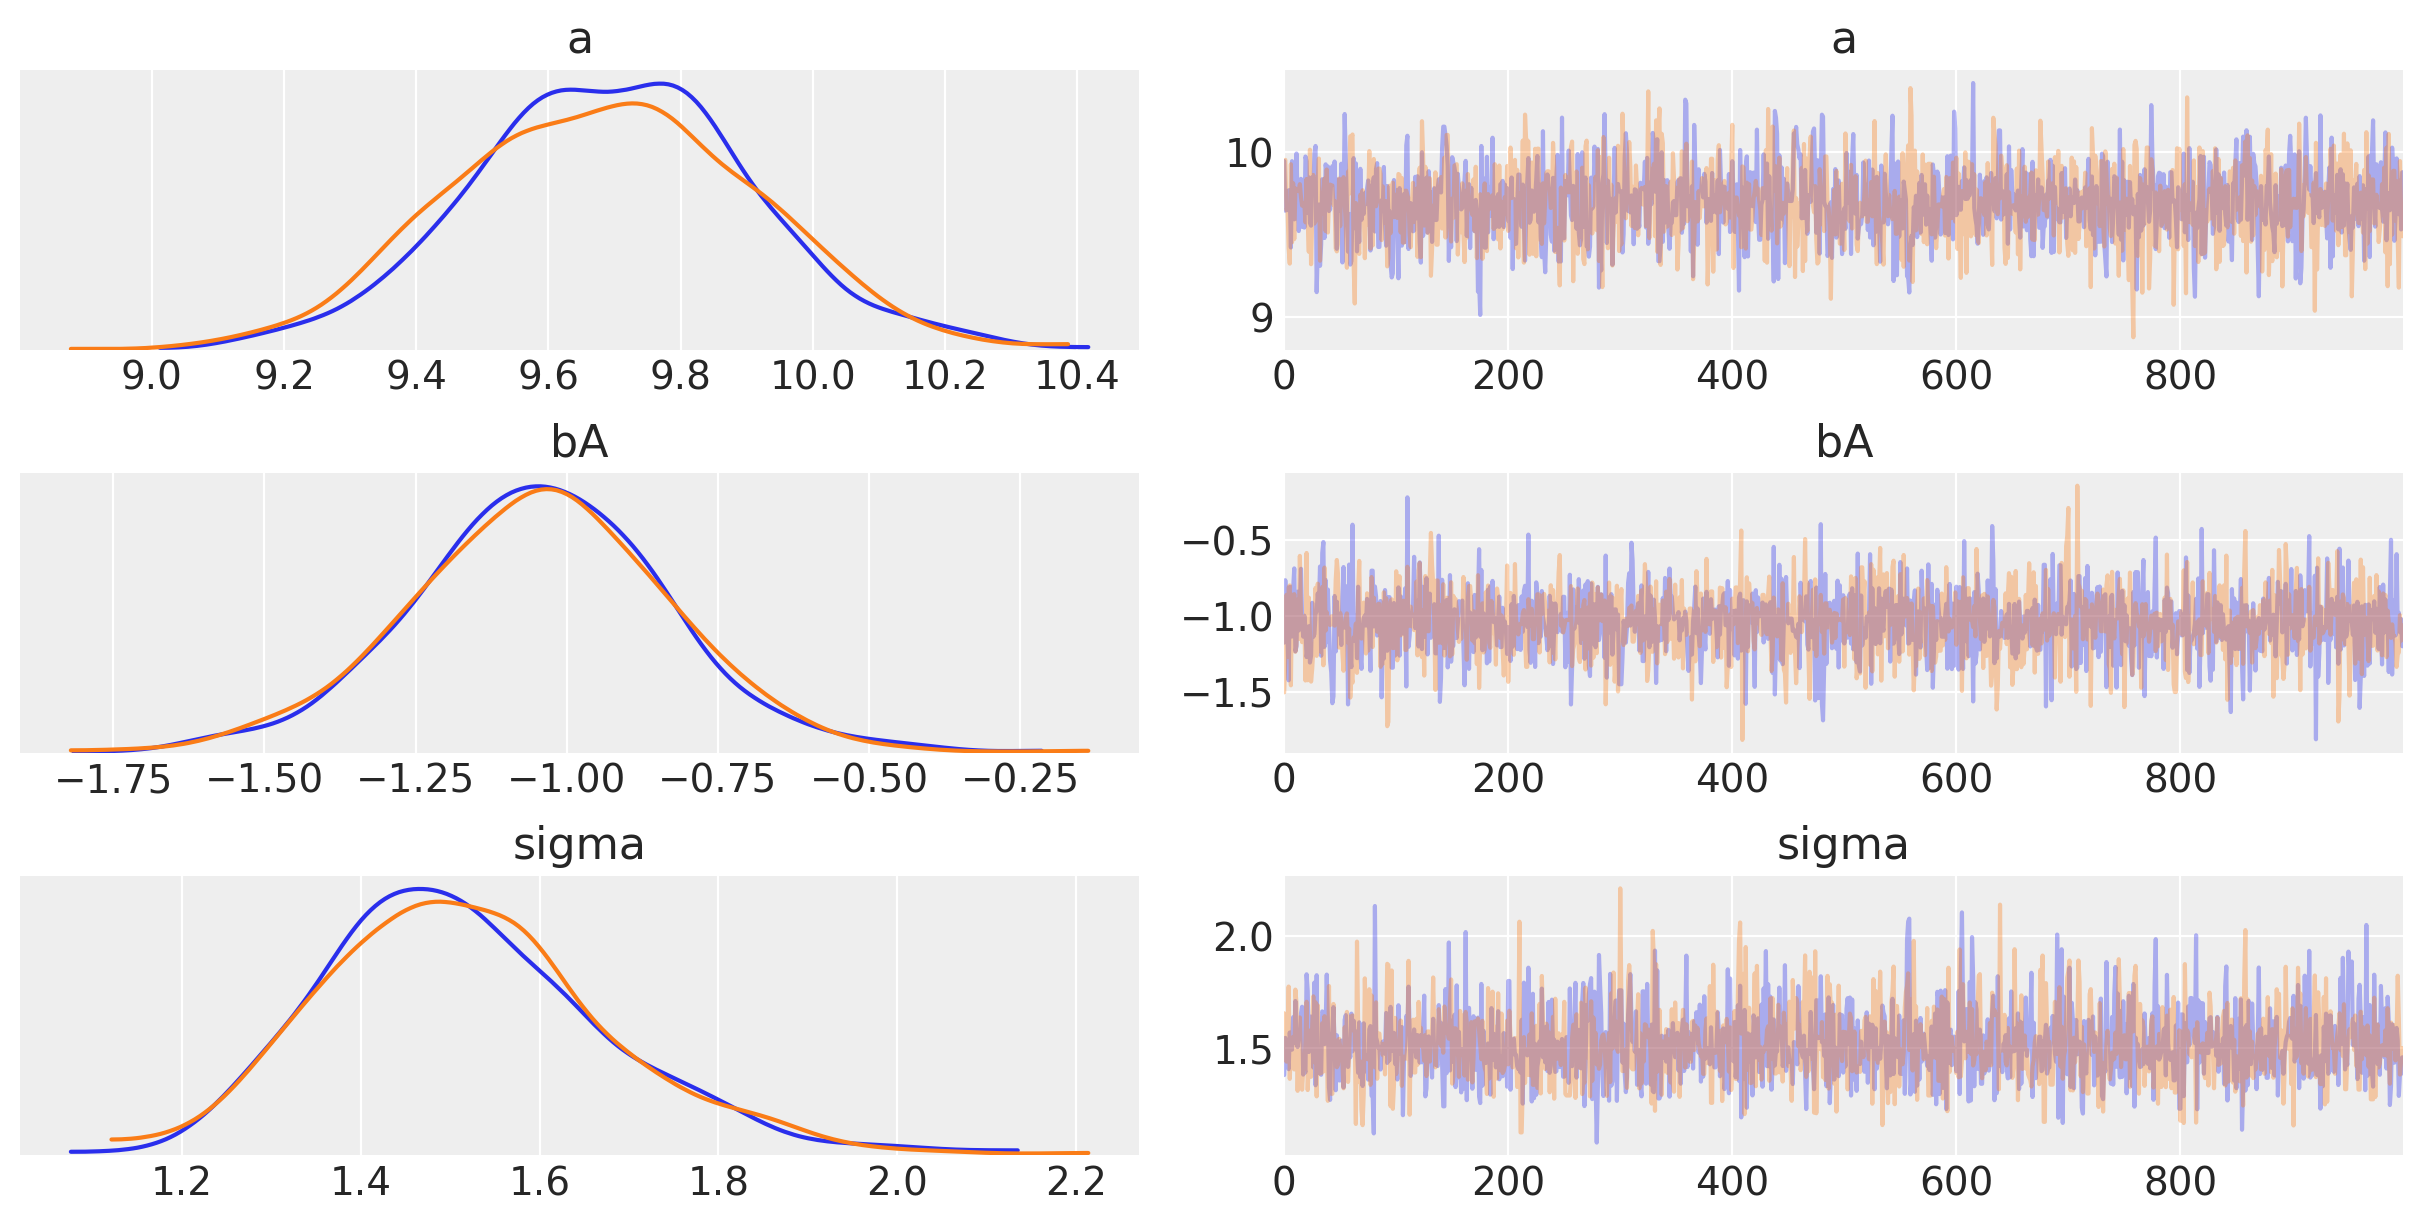

In [5]:
varnames = ["~mu"]
az.plot_trace(trace_5_1, varnames);

#### Code 5.2

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


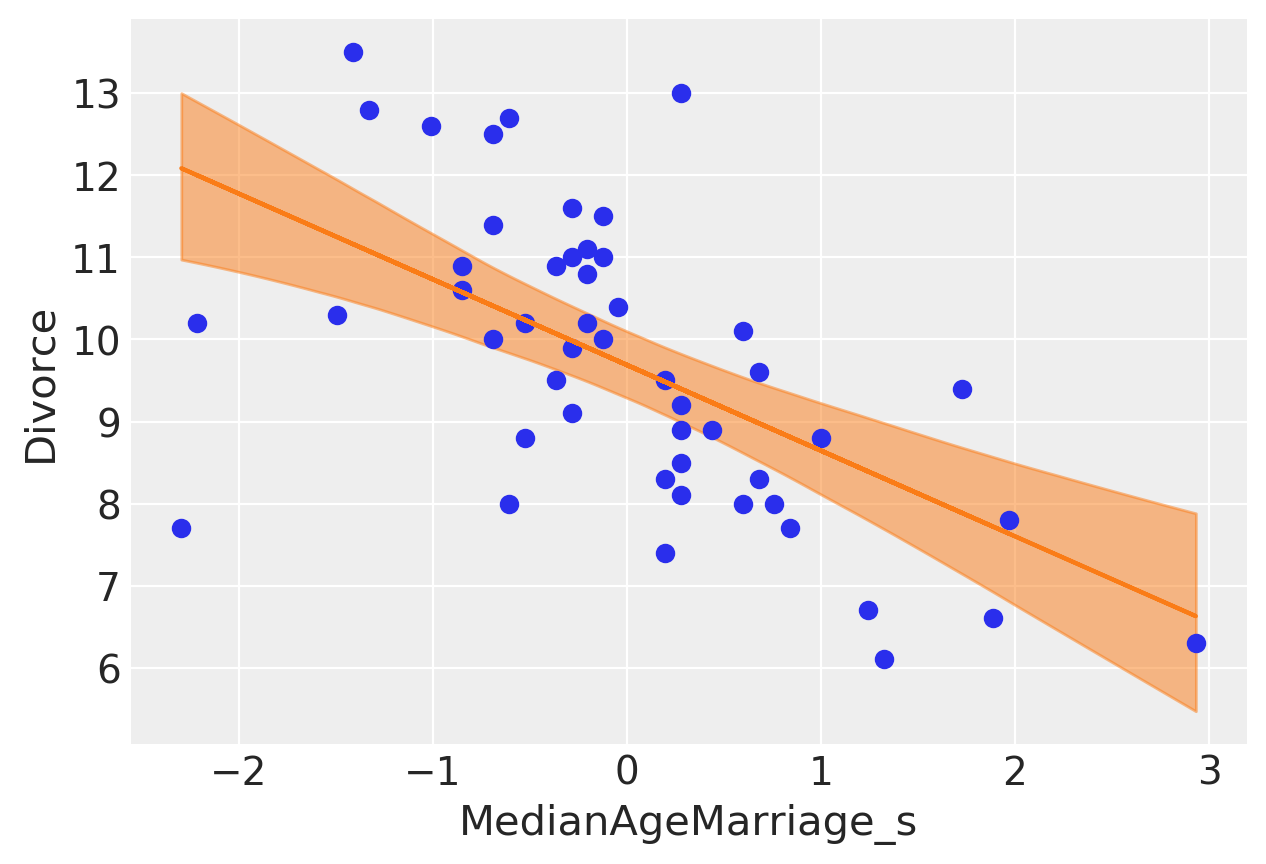

In [6]:
mu_mean = trace_5_1["mu"]

plt.plot(d.MedianAgeMarriage_s, d.Divorce, "C0o")
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), "C1")

az.plot_hpd(d.MedianAgeMarriage_s, mu_mean)

plt.xlabel("MedianAgeMarriage_s")
plt.ylabel("Divorce");

#### Code 5.3

In [7]:
d["Marriage_s"] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [8]:
with pm.Model() as model_5_2:
    a = pm.Normal("a", mu=10, sd=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic("mu", a + bA * d.Marriage_s)
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1788.44draws/s]


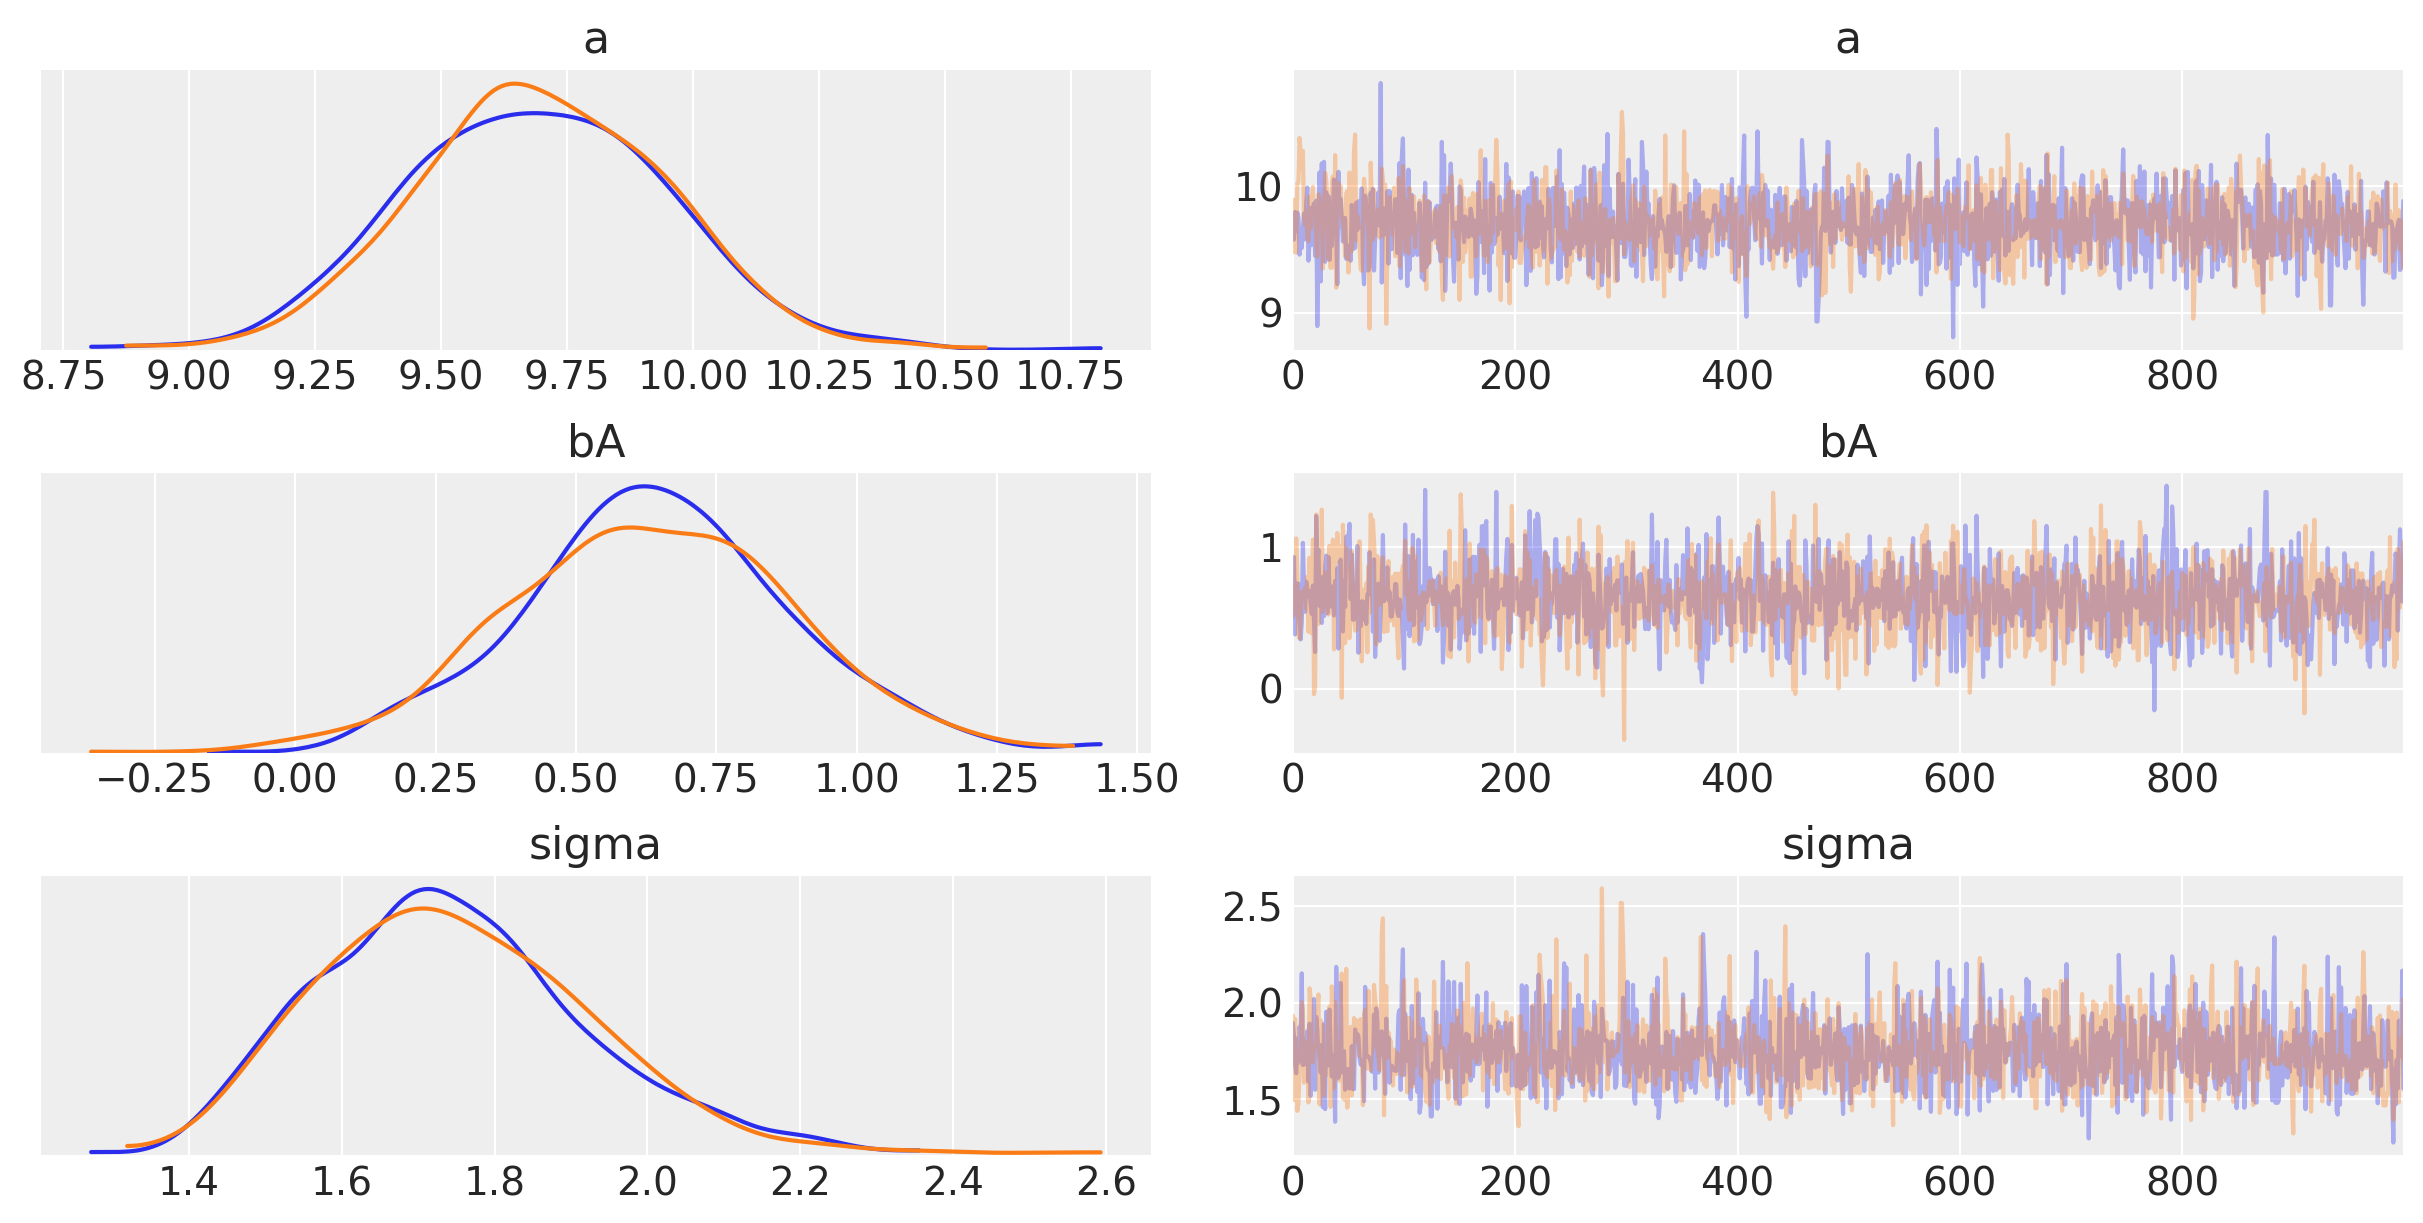

In [9]:
az.plot_trace(trace_5_2, varnames);

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


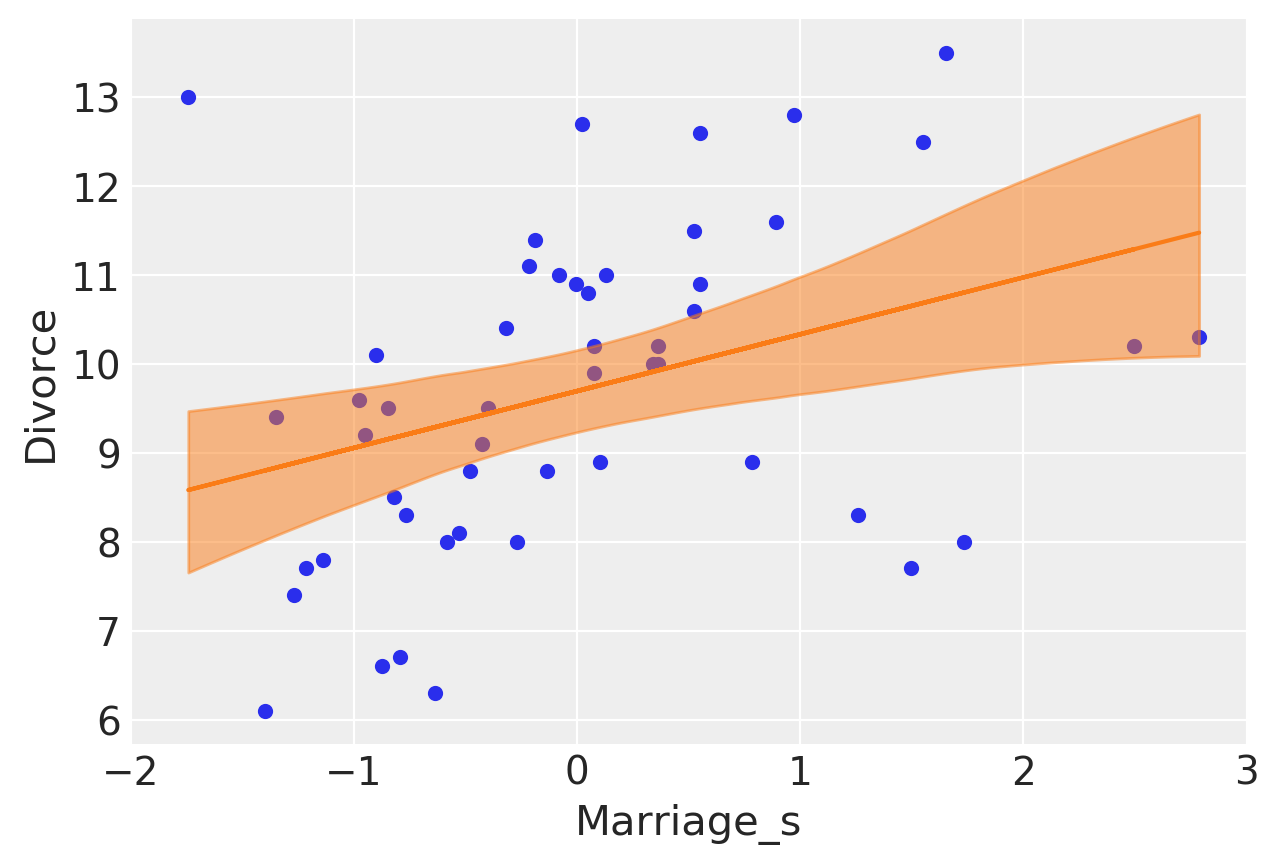

In [10]:
mu_mean = trace_5_2["mu"]

d.plot("Marriage_s", "Divorce", kind="scatter", xlim=(-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), "C1")

az.plot_hpd(d.Marriage_s, mu_mean);

#### Code 5.4

In [11]:
with pm.Model() as model_5_3:
    a = pm.Normal("a", mu=10, sd=10)
    bA = pm.Normal("bA", mu=0, sd=1, shape=2)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic(
        "mu", a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s
    )

    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1388.93draws/s]


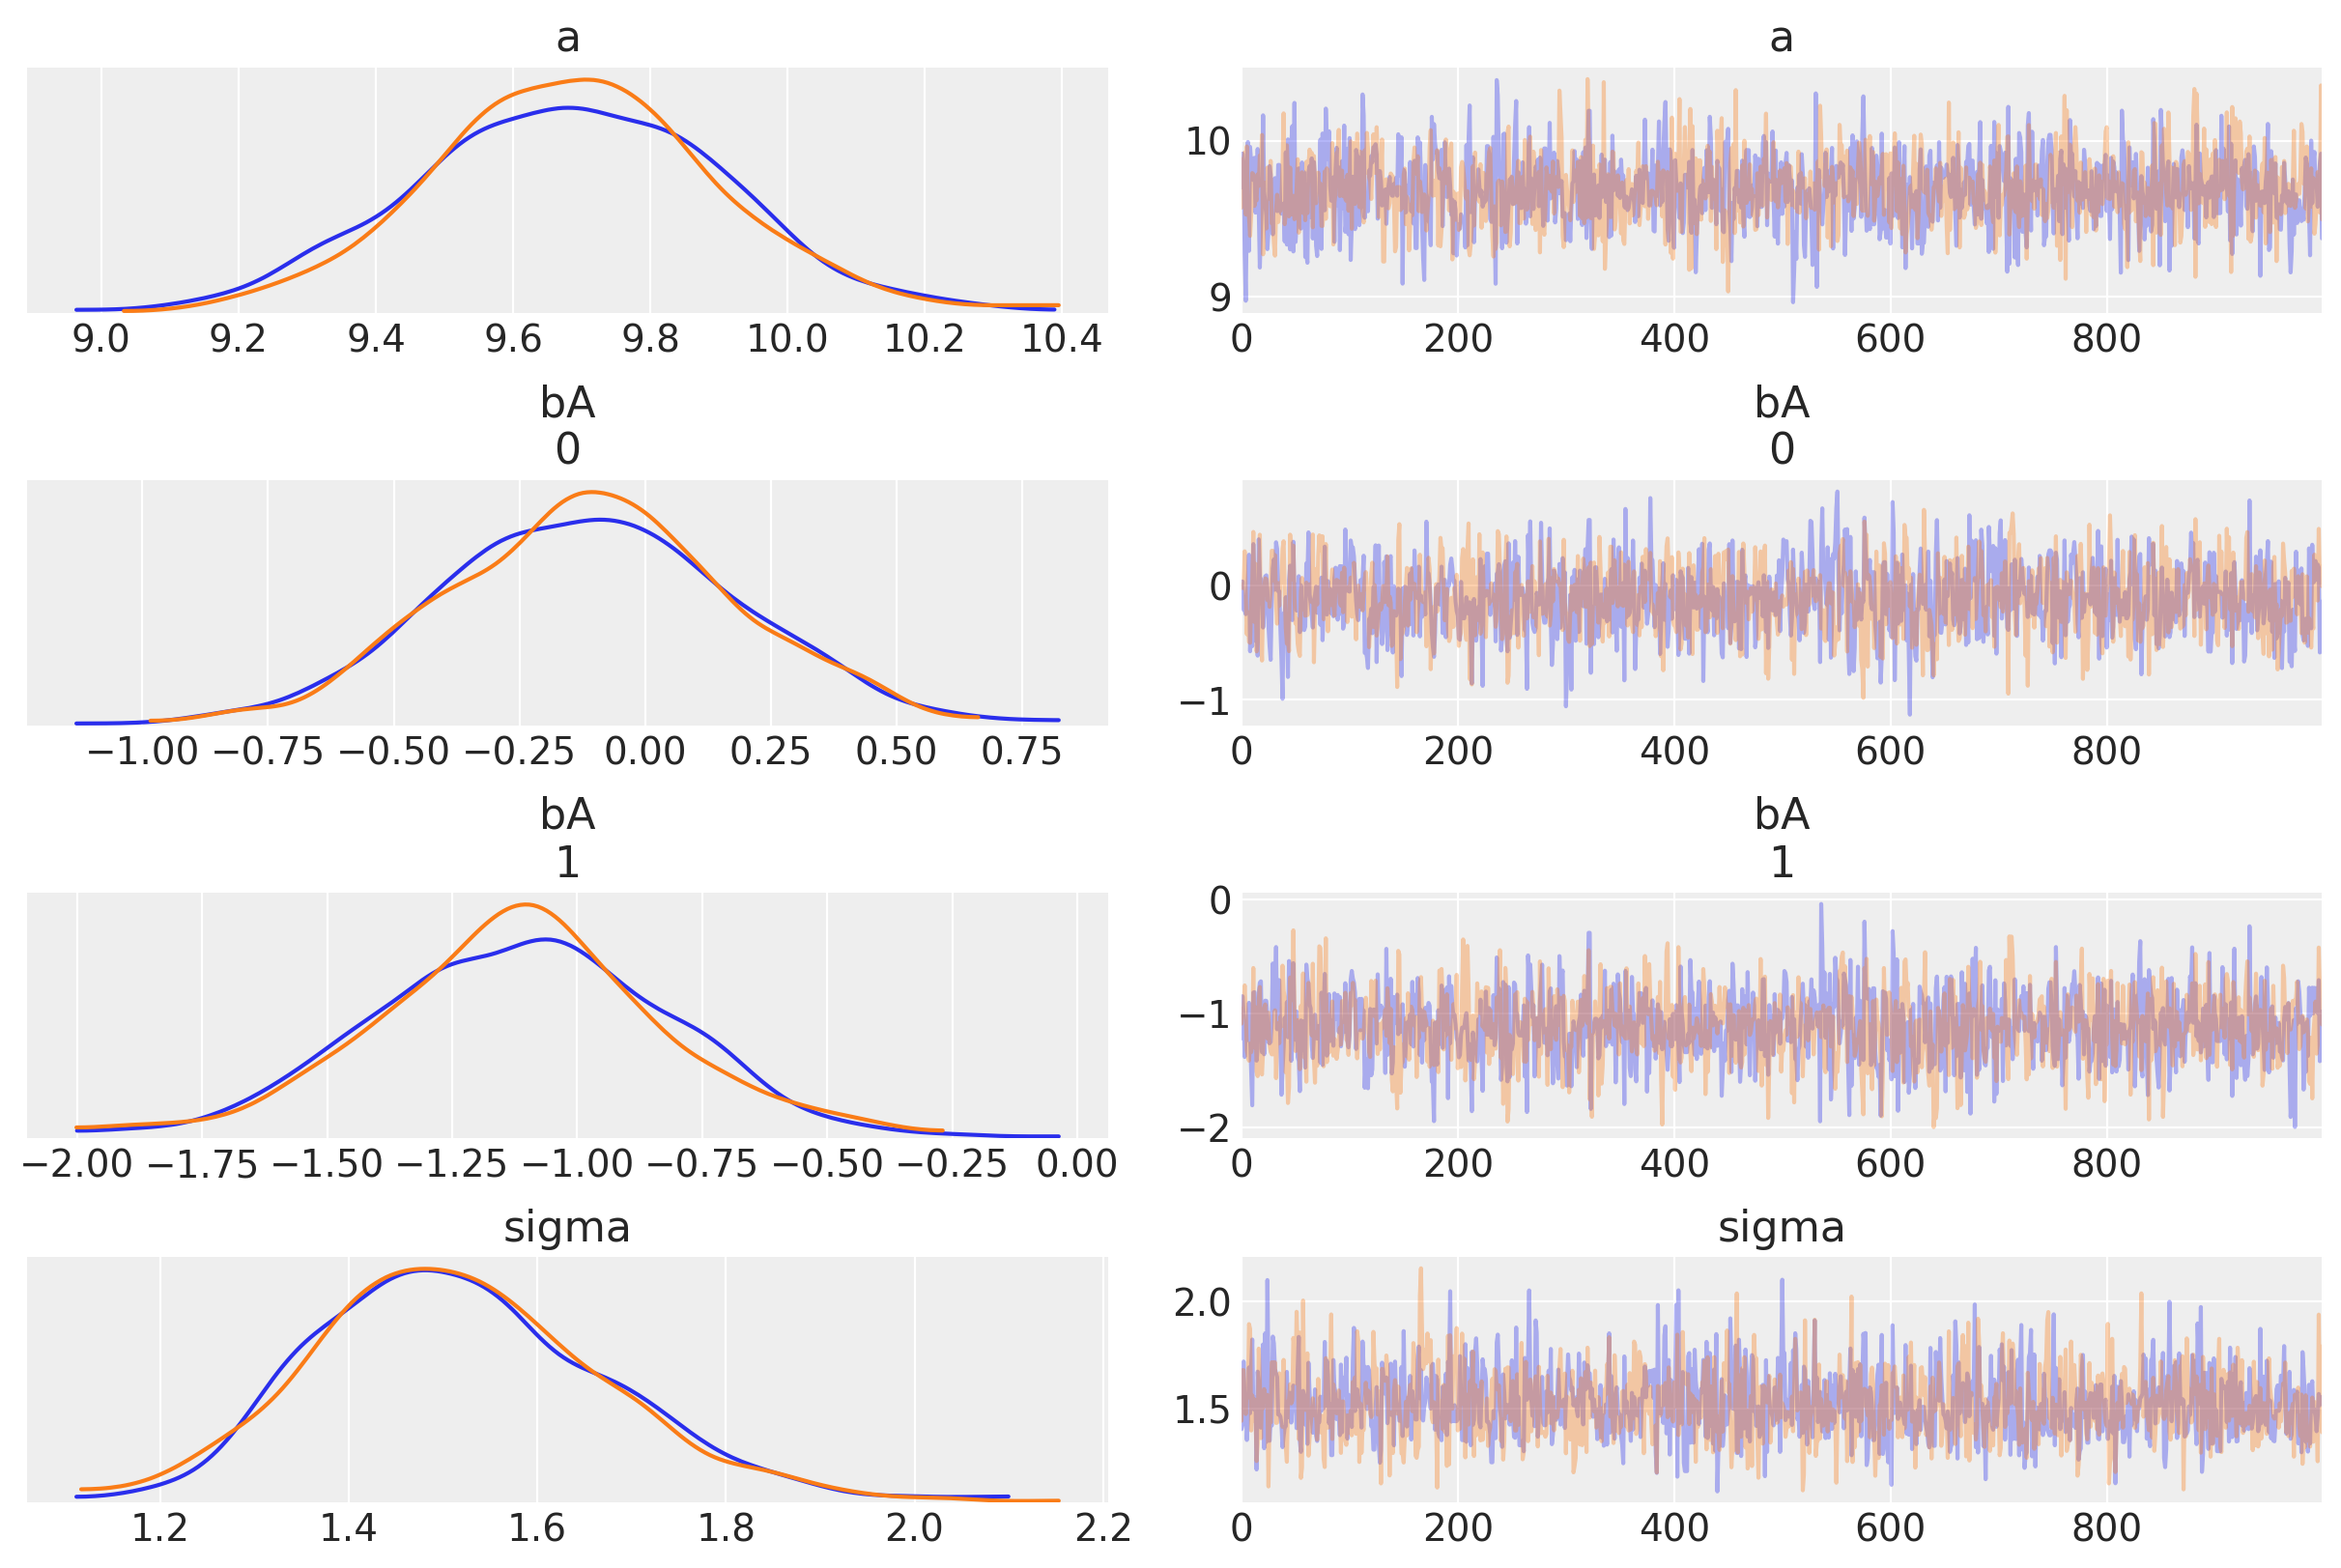

In [12]:
az.plot_trace(trace_5_3, varnames);

In [13]:
az.summary(trace_5_3, varnames, credible_interval=0.11).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_44.5%  hpd_55.5%  ess_mean  \
a      9.686  0.217      0.005    0.004      9.676      9.732    1827.0   
bA[0] -0.112  0.291      0.007    0.006     -0.173     -0.102    1551.0   
bA[1] -1.116  0.292      0.007    0.005     -1.129     -1.066    1611.0   
sigma  1.520  0.155      0.004    0.003      1.455      1.493    1652.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a      1824.0    1825.0    1632.0    1.0  
bA[0]  1150.0    1550.0    1456.0    1.0  
bA[1]  1601.0    1605.0    1525.0    1.0  
sigma  1640.0    1660.0    1436.0    1.0

#### Code 5.5

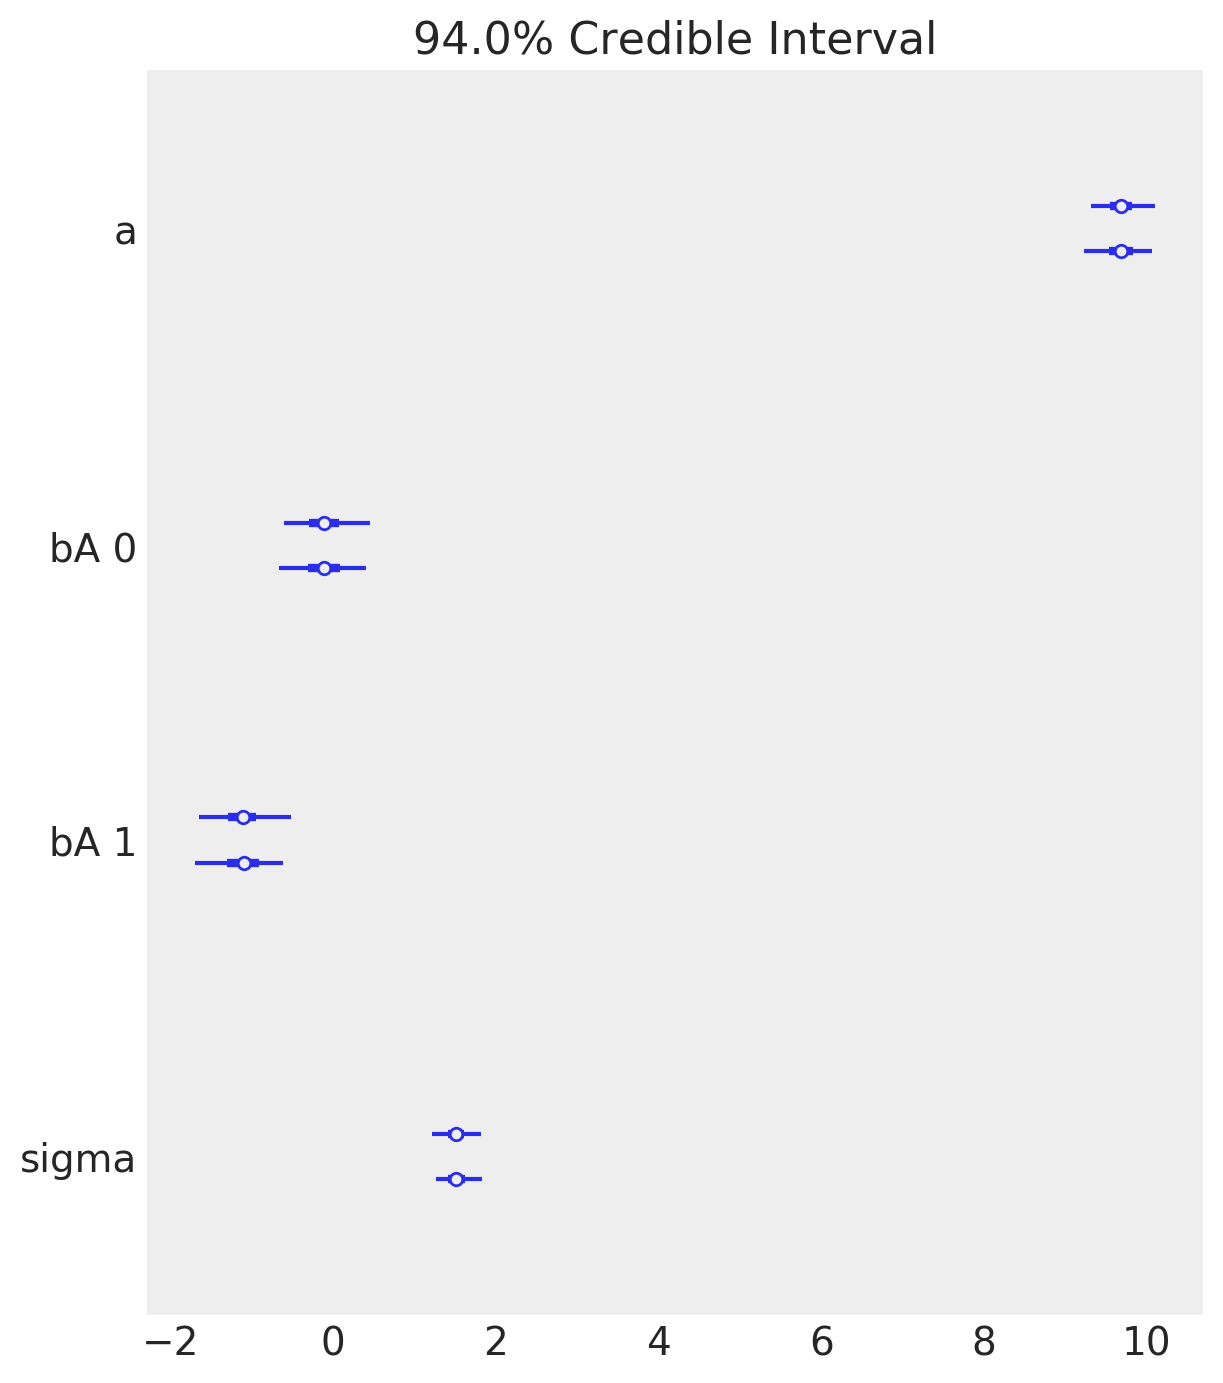

In [14]:
pm.forestplot(trace_5_3, var_names=varnames);

#### Code 5.6

In [15]:
with pm.Model() as model_5_4:
    a = pm.Normal("a", mu=10, sd=10)
    b = pm.Normal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic("mu", a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal("Marriage", mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1764.35draws/s]


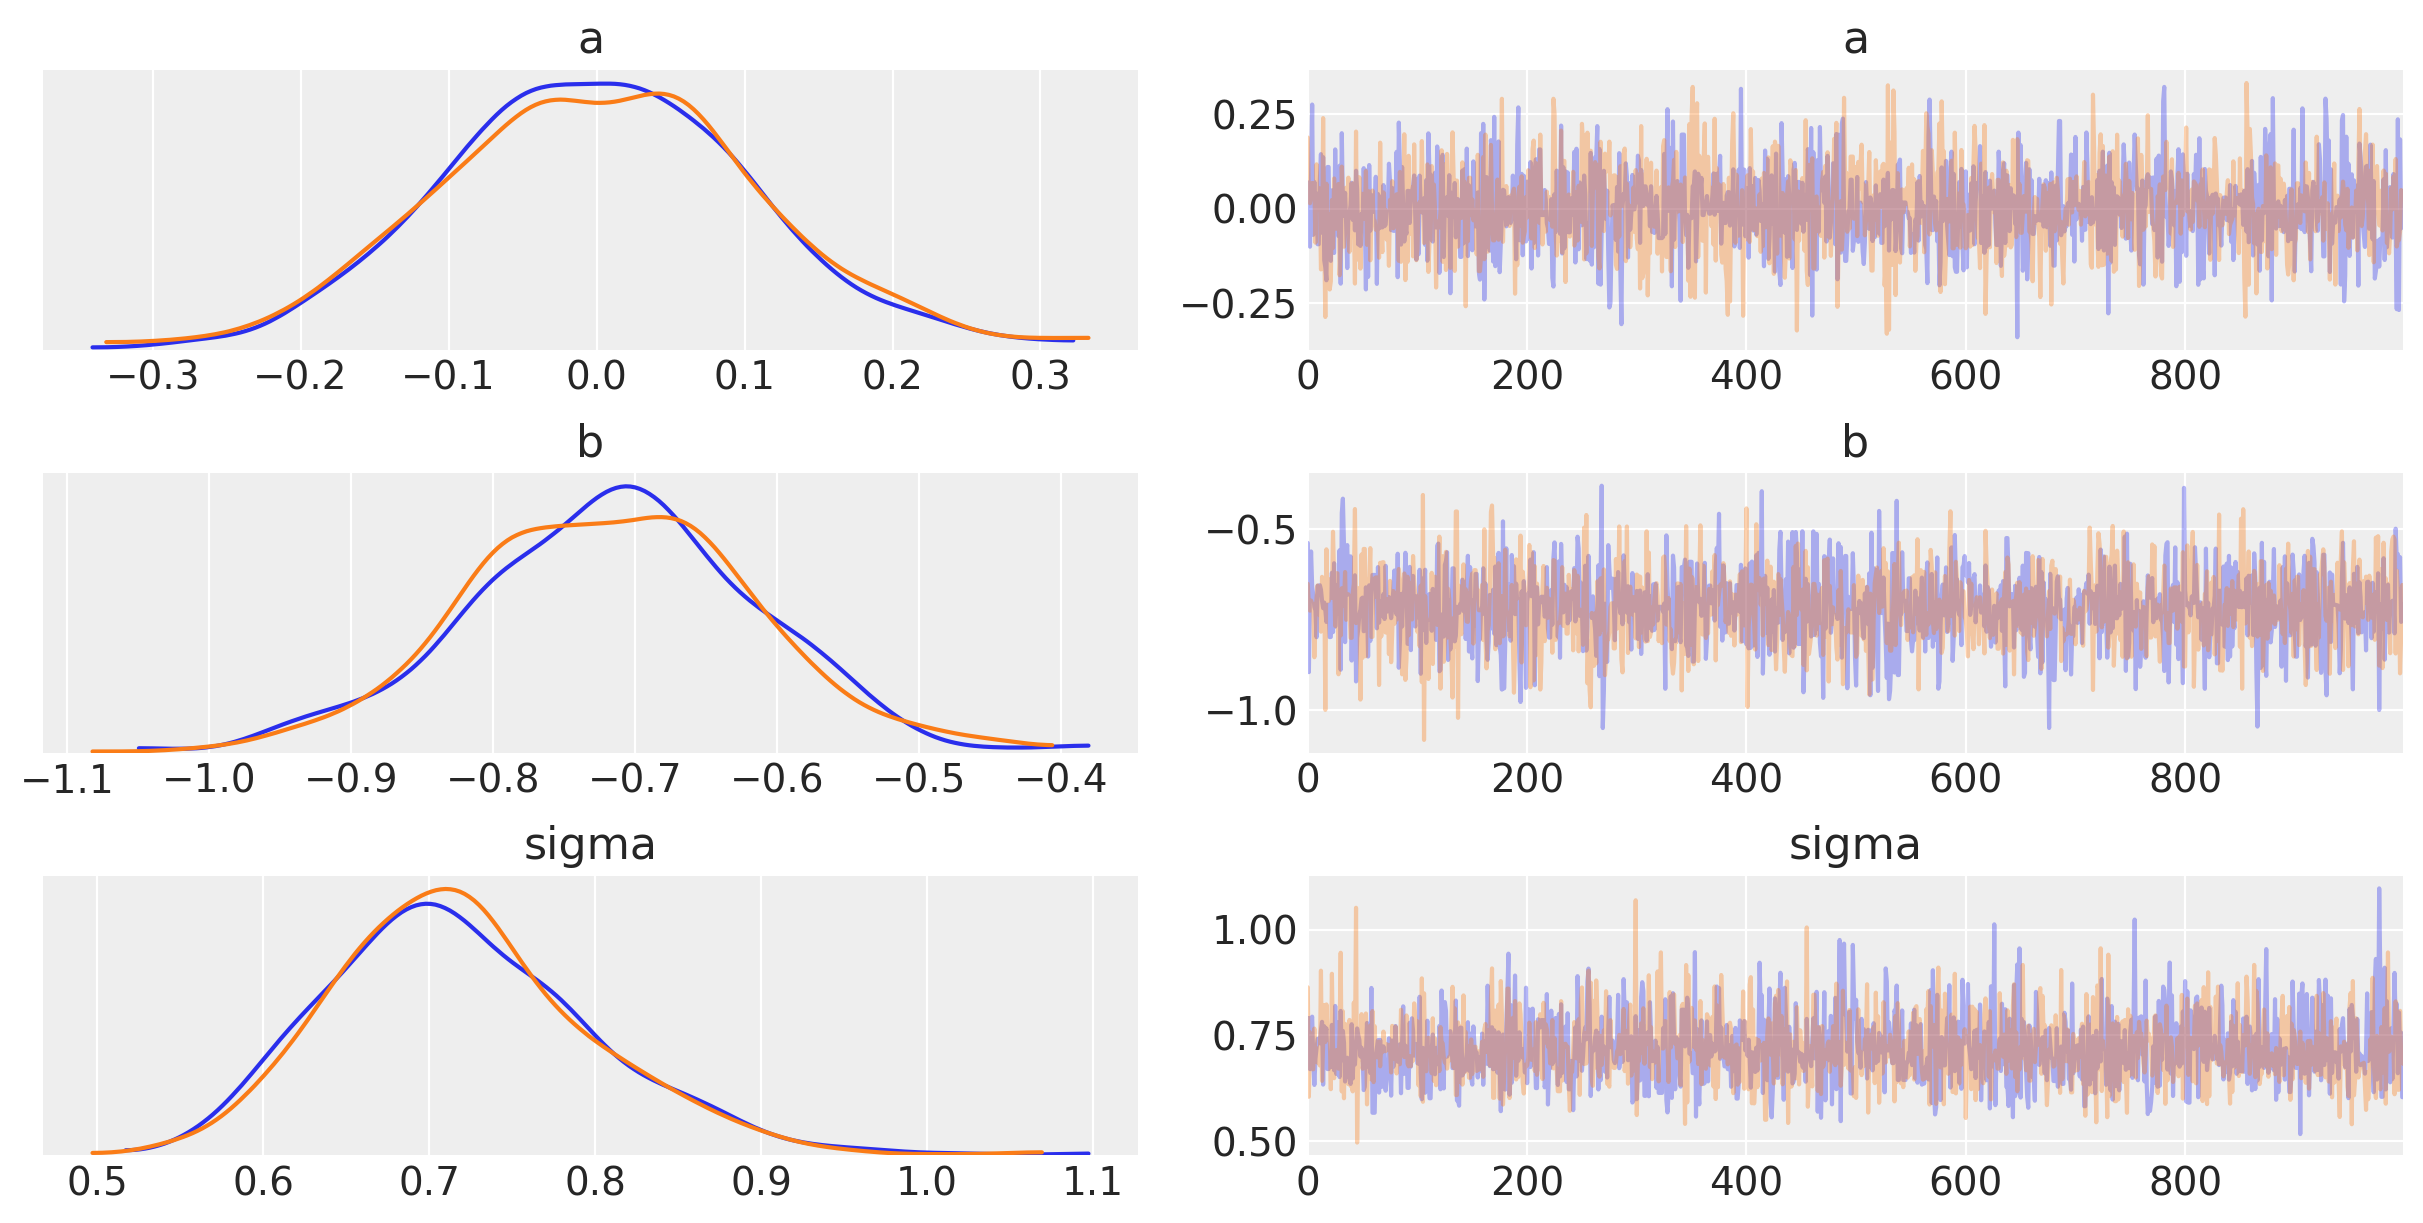

In [16]:
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [17]:
mu_pred = trace_5_4["mu"].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

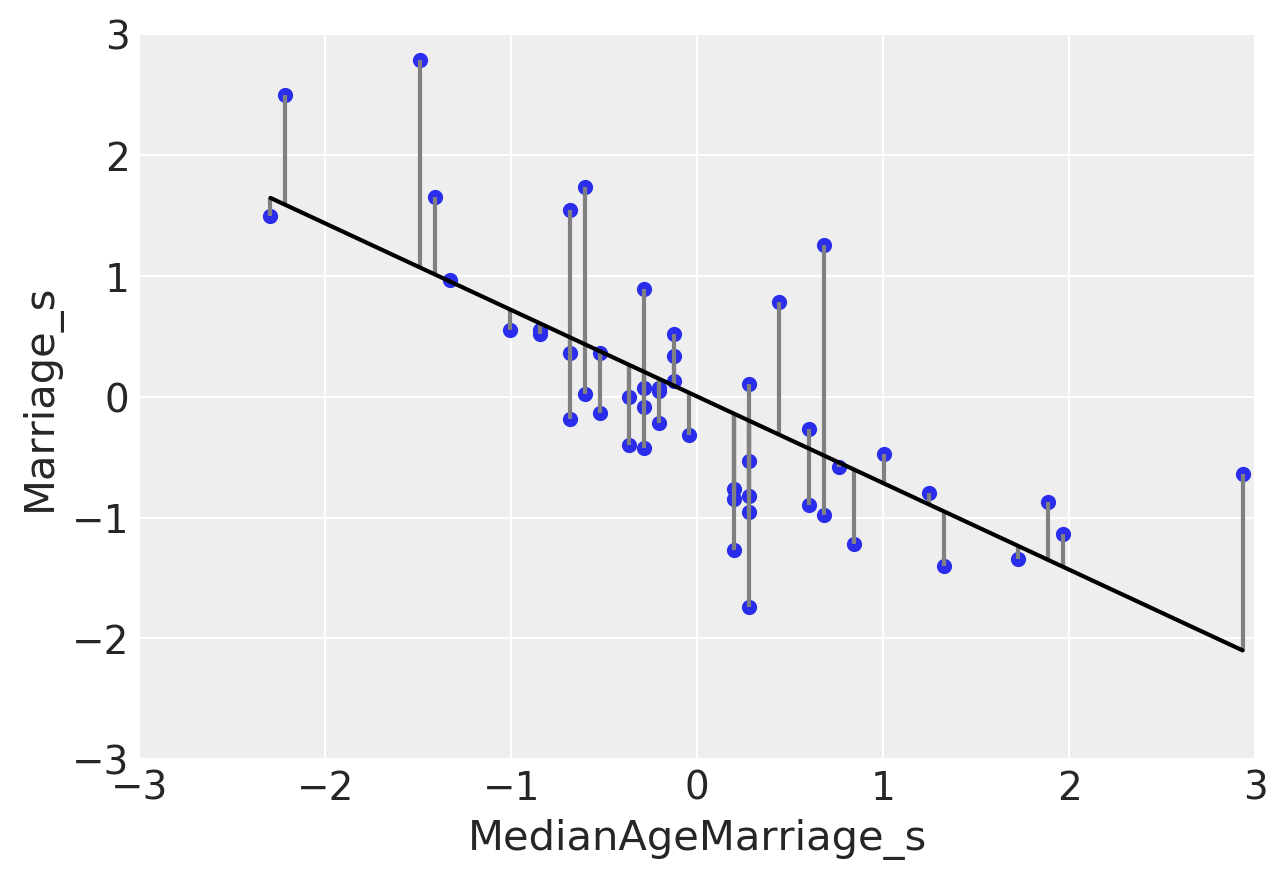

In [18]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot("MedianAgeMarriage_s", "Marriage_s", kind="scatter", xlim=(-3, 3), ylim=(-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], "k")
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors="grey");

#### Code 5.9

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


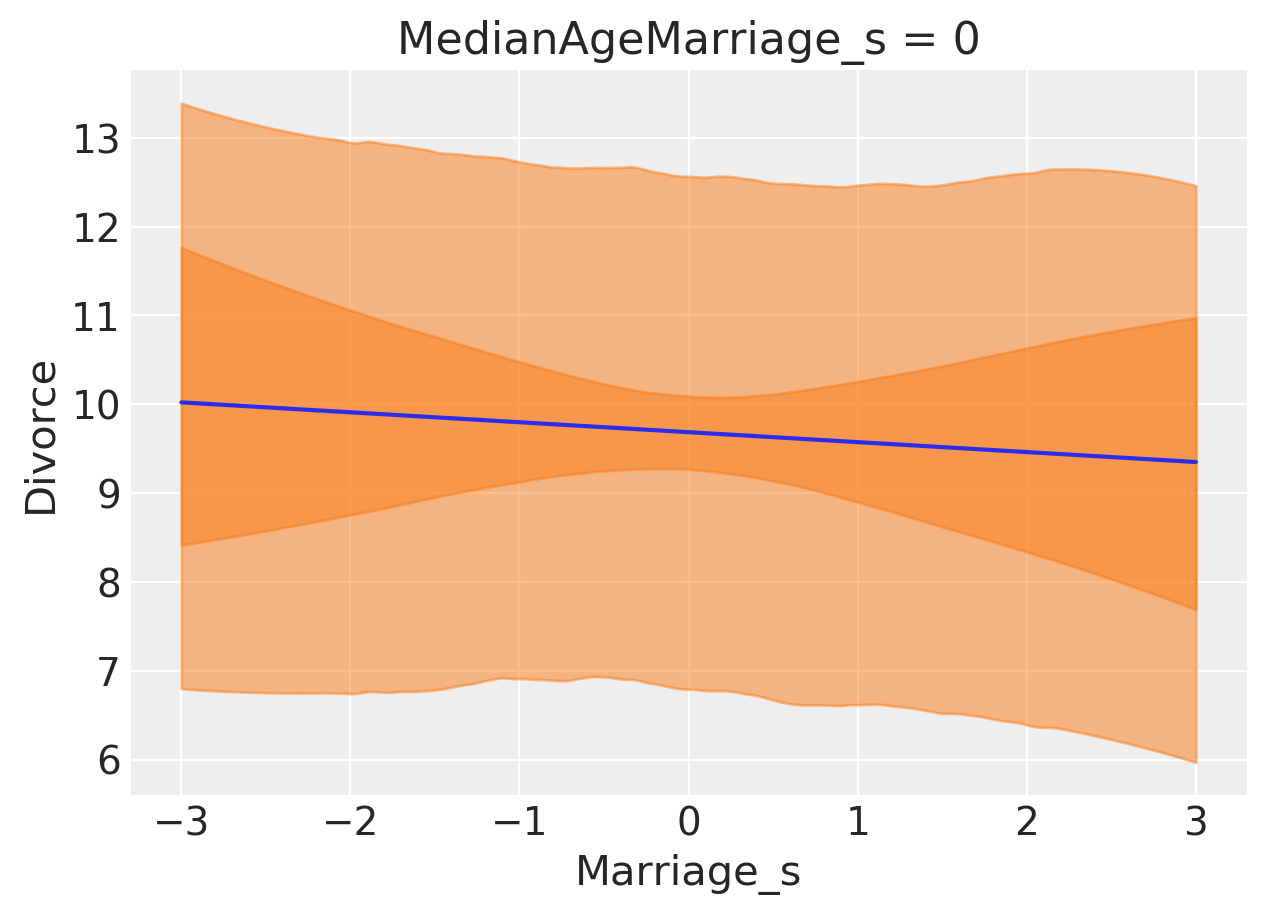

In [19]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3["a"] + trace_5_3["bA"][:, 0] * R_avg[:, None]
divorce_ = stats.norm.rvs(mu_pred, trace_5_3["sigma"])

plt.plot(R_avg, mu_pred.mean(1), "C0")
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, divorce_.T)

plt.xlabel("Marriage_s")
plt.ylabel("Divorce")
plt.title("MedianAgeMarriage_s = 0");

#### Code 5.10

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


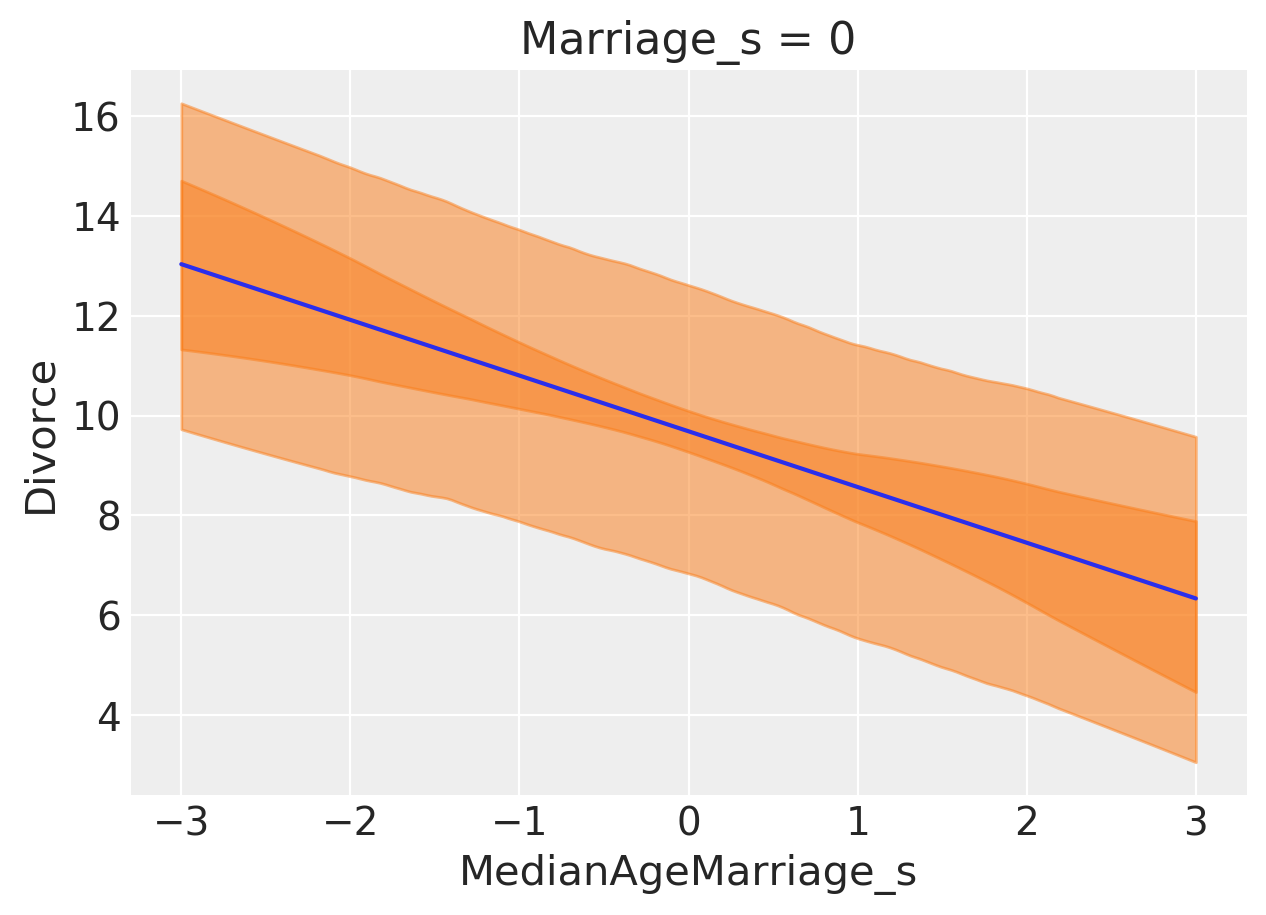

In [20]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3["a"] + trace_5_3["bA"][:, 1] * R_avg[:, None]
divorce_ = stats.norm.rvs(mu_pred, trace_5_3["sigma"])

plt.plot(R_avg, mu_pred.mean(1), "C0")
az.plot_hpd(R_avg, mu_pred.T)
az.plot_hpd(R_avg, divorce_.T)

plt.xlabel("MedianAgeMarriage_s")
plt.ylabel("Divorce")
plt.title("Marriage_s = 0");

#### Code 5.11

In [21]:
mu_pred = trace_5_3["mu"]

divorce_pred = pm.sample_posterior_predictive(trace_5_3, samples=1000, model=model_5_3)[
    "Divorce"
]
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:01<00:00, 904.76it/s]


#### Code 5.12

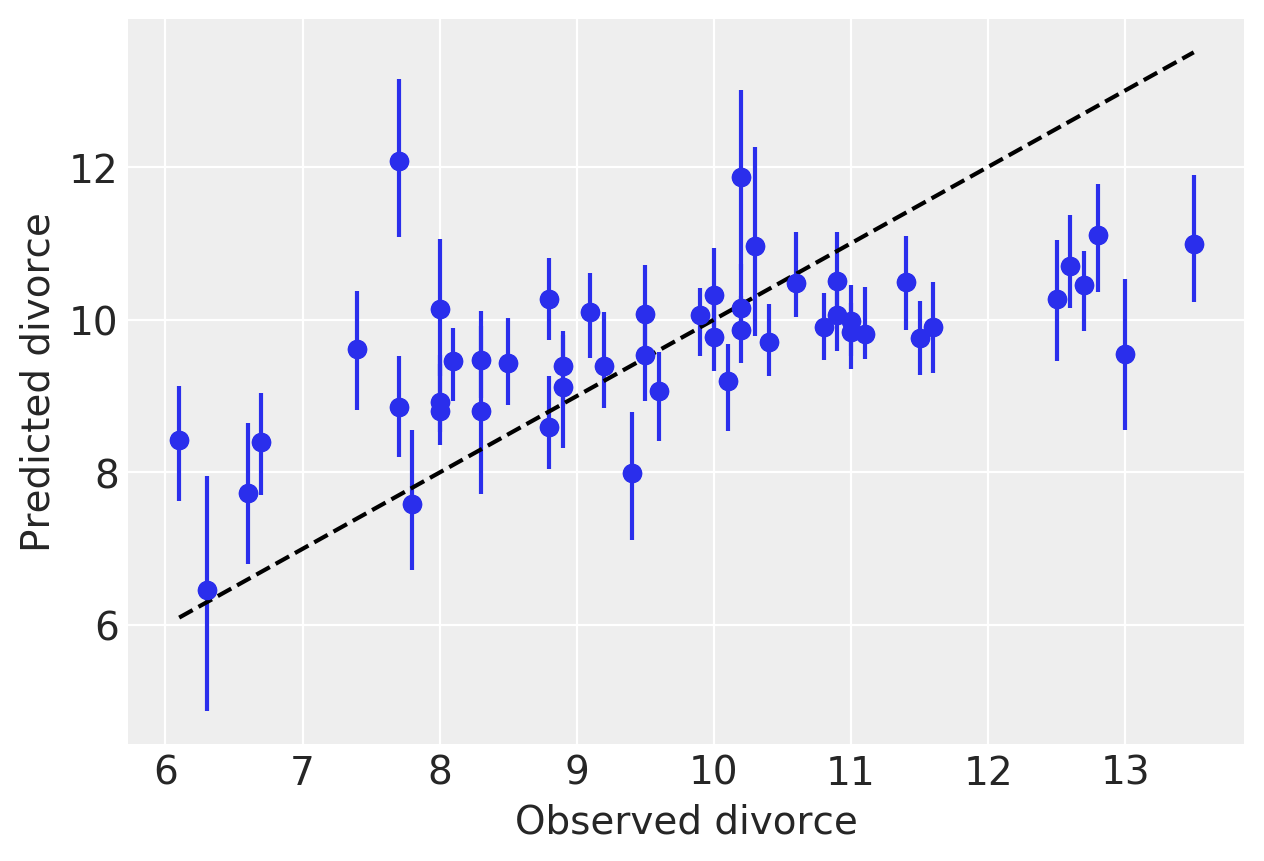

In [22]:
mu_hpd = az.hpd(mu_pred, credible_interval=0.95)
plt.errorbar(
    d.Divorce,
    divorce_pred.mean(0),
    yerr=np.abs(divorce_pred.mean(0) - mu_hpd.T),
    fmt="C0o",
)
plt.plot(d.Divorce, divorce_pred.mean(0), "C0o")

plt.xlabel("Observed divorce", fontsize=14)
plt.ylabel("Predicted divorce", fontsize=14)

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], "k--");

#### Code 5.14

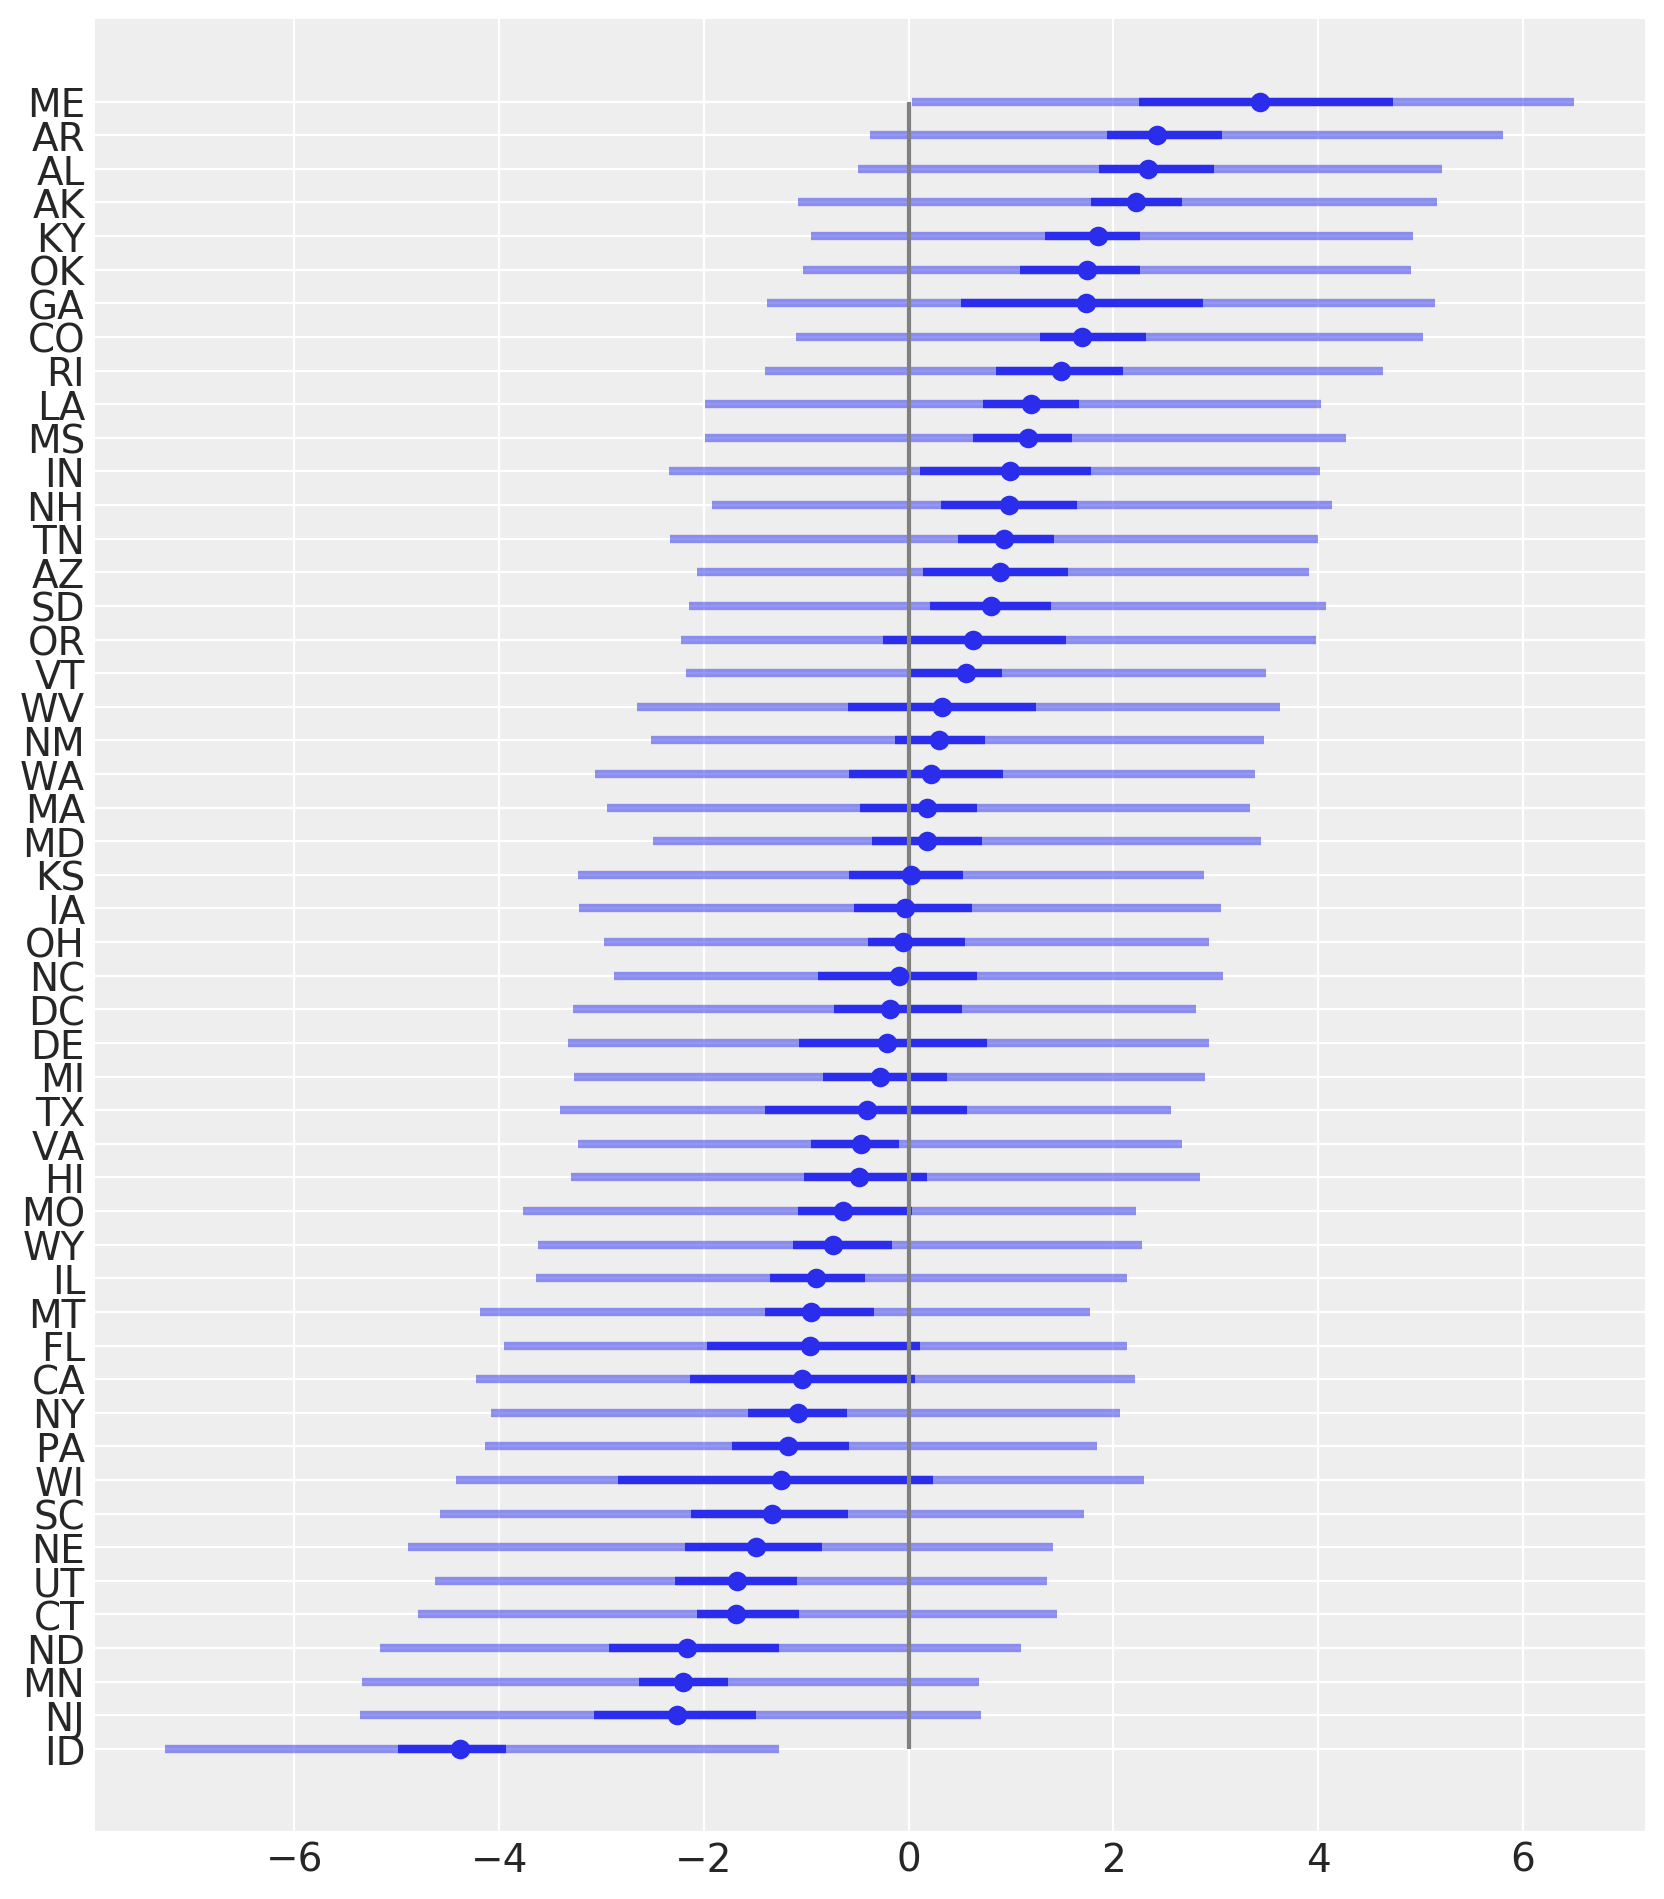

In [23]:
plt.figure(figsize=(10, 12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(
    residuals[idx],
    y_points,
    xerr=np.abs(divorce_pred.mean(0) - mu_hpd.T),
    fmt="C0o",
    lw=3,
)

plt.errorbar(
    residuals[idx],
    y_points,
    xerr=np.abs(divorce_pred.mean(0) - divorce_hpd.T),
    fmt="C0o",
    lw=3,
    alpha=0.5,
)

plt.yticks(y_points, y_label)
plt.vlines(0, 0, 1, "grey");

#### Code 5.15

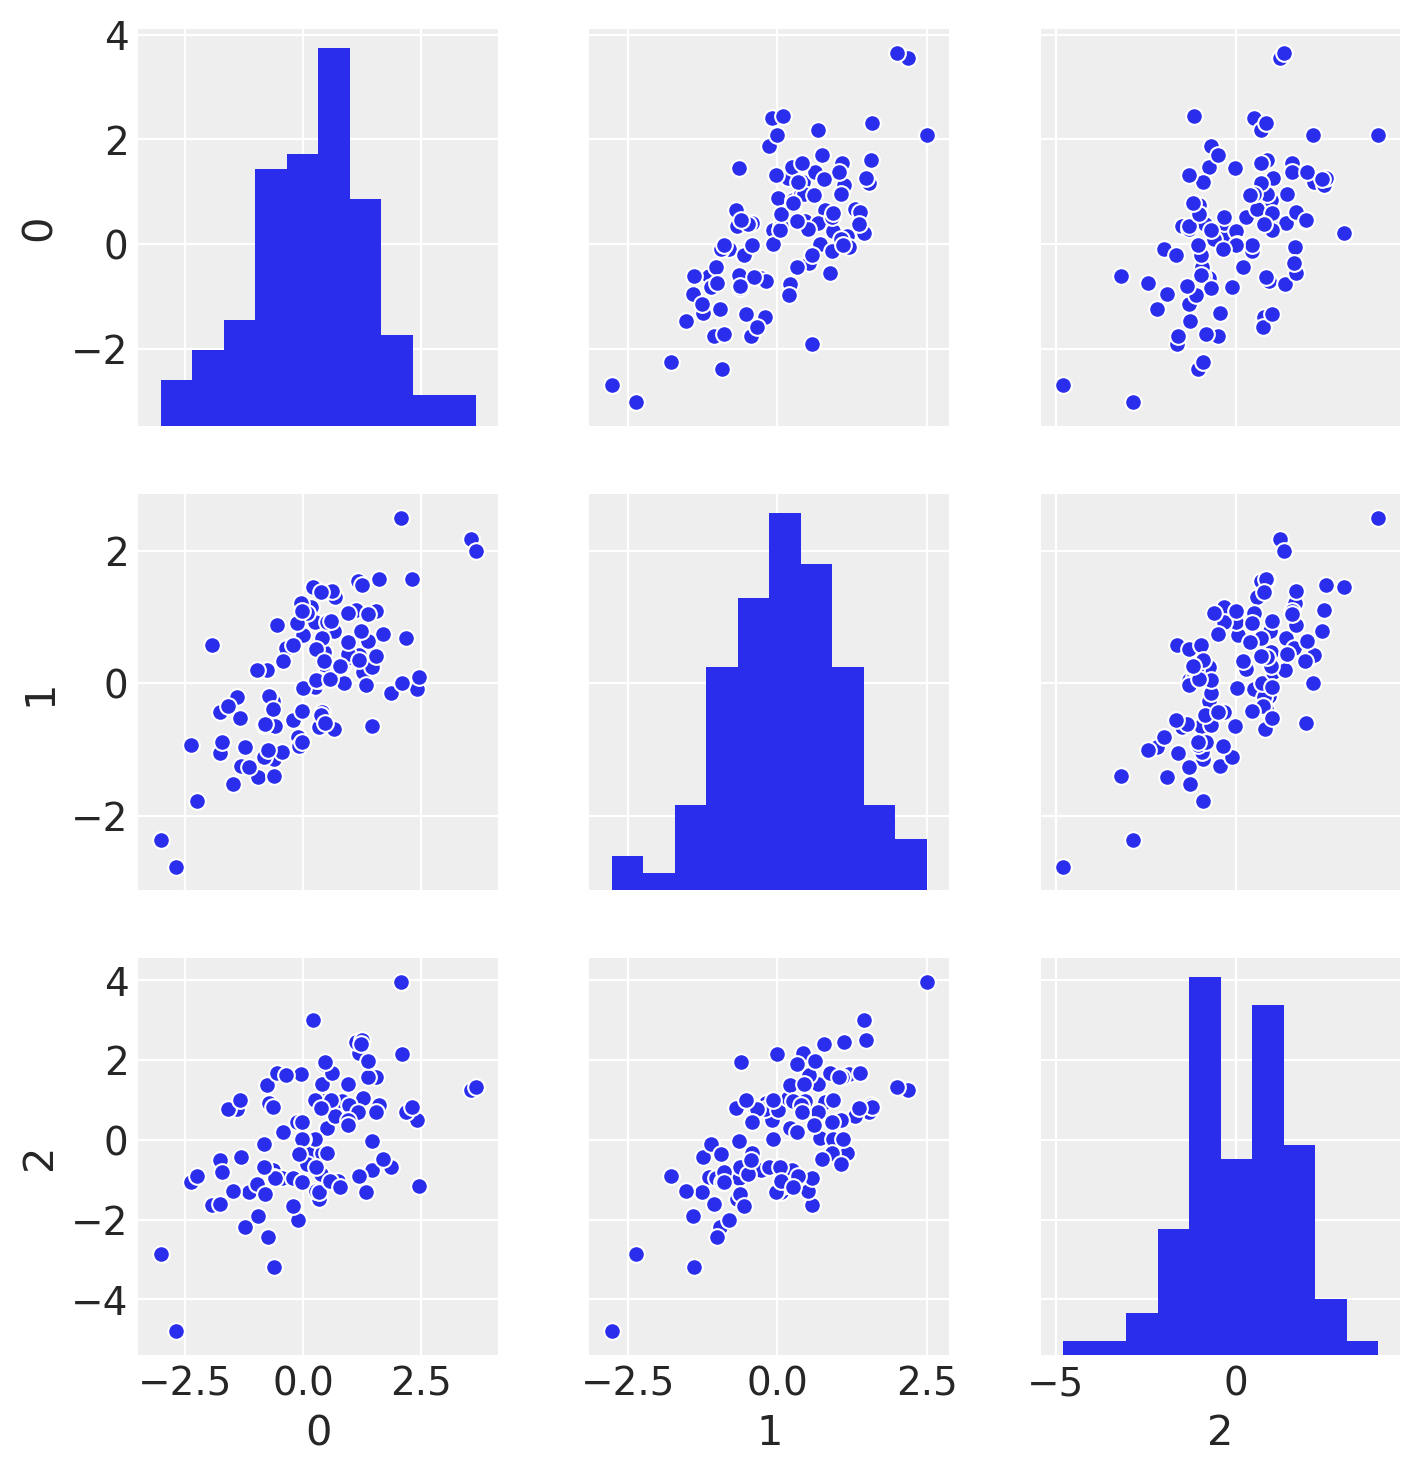

In [24]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [25]:
d = pd.read_csv("Data/milk.csv", sep=";")
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

#### Code 5.17 to 5.20

In [26]:
dcc = d.dropna().copy()

In [27]:
with pm.Model() as model_5_5:
    a = pm.Normal("a", mu=10, sd=100)
    bn = pm.Normal("bn", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal = pm.Normal("kcal", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 399.15draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7186944095692311, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


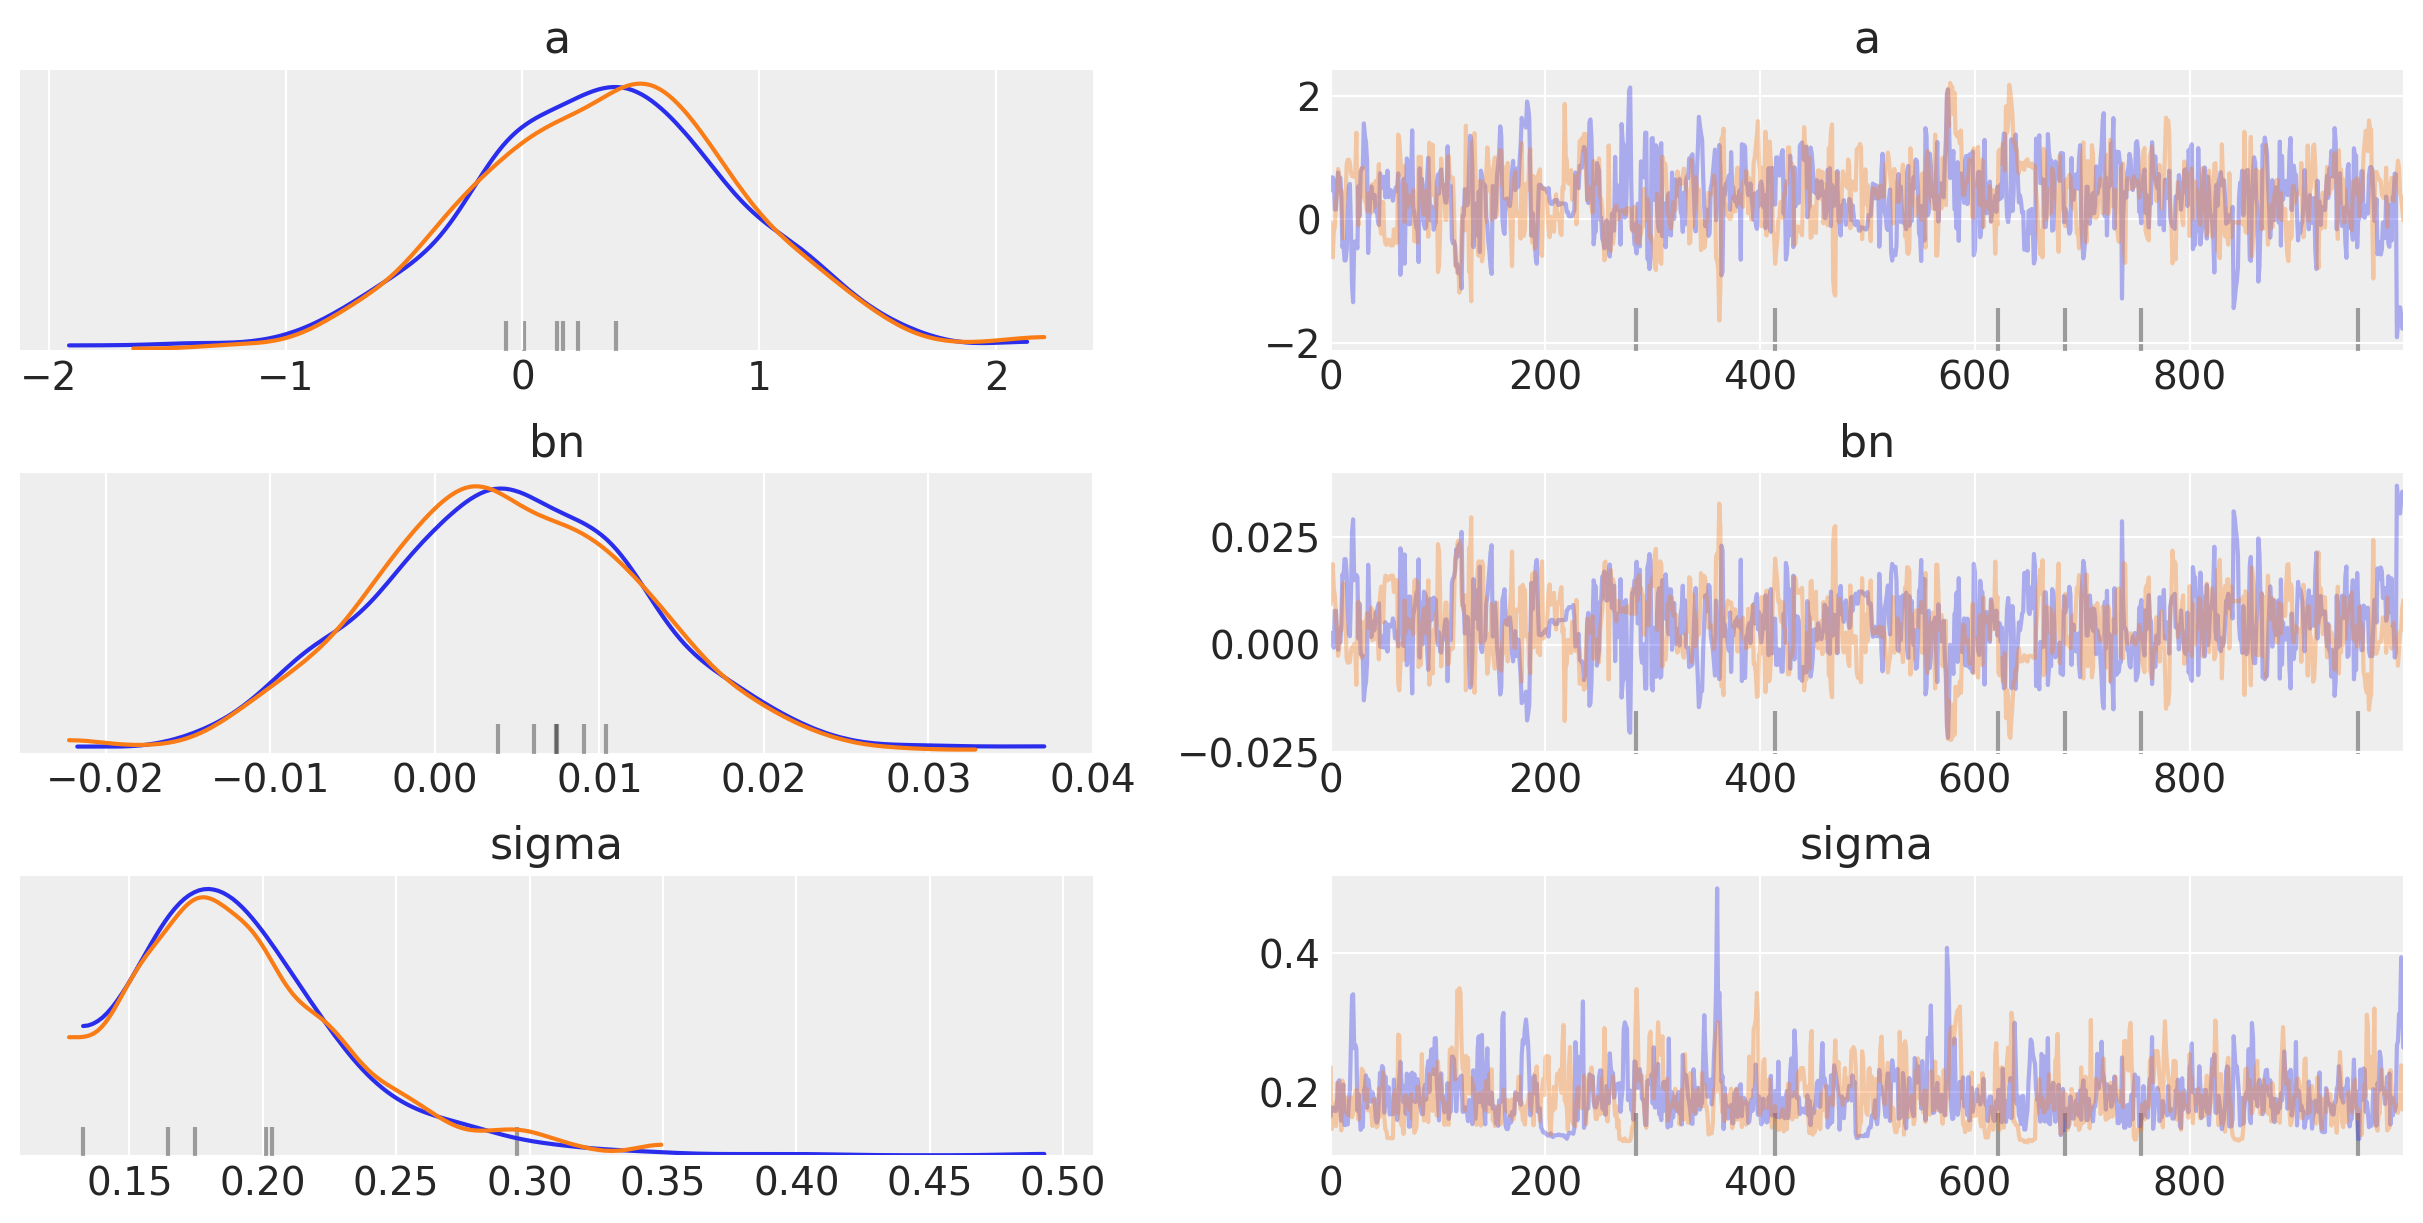

In [28]:
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [29]:
az.summary(trace_5_5, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      0.359  0.572      0.028    0.021    -0.518      1.264     423.0   
bn     0.004  0.008      0.000    0.000    -0.010      0.017     421.0   
sigma  0.194  0.040      0.002    0.001     0.130      0.245     456.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       389.0     439.0     505.0   1.01  
bn      421.0     433.0     511.0   1.01  
sigma   456.0     370.0     180.0   1.01

#### Code 5.22

In [30]:
trace_5_5["bn"].mean() * (76 - 55)

0.09271430038541924

#### Code 5.23

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


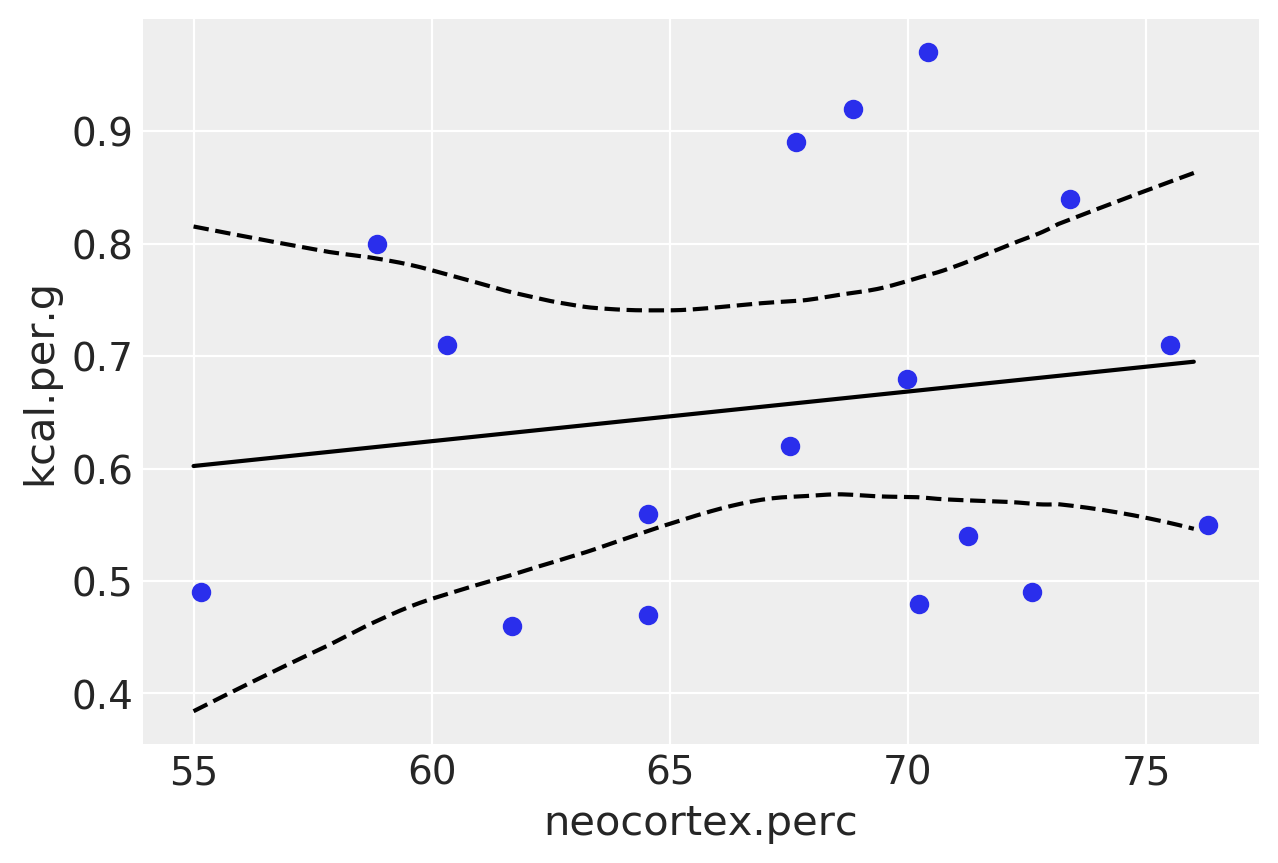

In [31]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5["a"] + trace_5_5["bn"] * seq[:, None]

plt.plot(d["neocortex.perc"], d["kcal.per.g"], "C0o")

plt.plot(seq, mu_pred.mean(1), "k")
az.plot_hpd(
    seq,
    mu_pred.T,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"alpha": 1, "color": "k", "ls": "--"},
)

plt.xlabel("neocortex.perc")
plt.ylabel("kcal.per.g");

#### Code 5.24

In [32]:
dcc["log_mass"] = np.log(dcc["mass"])

#### Code 5.25

In [33]:
with pm.Model() as model_5_6:
    a = pm.Normal("a", mu=10, sd=100)
    bn = pm.Normal("bn", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    mu = pm.Deterministic("mu", a + bn * dcc["log_mass"])
    kcal = pm.Normal("kcal", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1465.22draws/s]


In [34]:
az.summary(trace_5_6, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      0.706  0.060      0.002    0.001     0.604      0.792    1268.0   
bn    -0.032  0.024      0.001    0.001    -0.070      0.007    1167.0   
sigma  0.182  0.038      0.001    0.001     0.125      0.234     924.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a      1268.0    1293.0    1127.0    1.0  
bn     1135.0    1176.0    1105.0    1.0  
sigma   877.0    1009.0     879.0    1.0

#### Code 5.26

In [35]:
with pm.Model() as model_5_7:
    a = pm.Normal("a", mu=10, sd=100)
    bn = pm.Normal("bn", mu=0, sd=1, shape=2)
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    mu = pm.Deterministic(
        "mu", a + bn[0] * dcc["neocortex.perc"] + bn[1] * dcc["log_mass"]
    )
    kcal = pm.Normal("kcal", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 251.01draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [36]:
az.summary(trace_5_7, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a     -1.100  0.572      0.027    0.019    -1.977     -0.244     445.0   
bn[0]  0.028  0.009      0.000    0.000     0.014      0.042     436.0   
bn[1] -0.097  0.029      0.001    0.001    -0.139     -0.046     503.0   
sigma  0.140  0.029      0.001    0.001     0.096      0.177     489.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       445.0     449.0     663.0    1.0  
bn[0]   436.0     442.0     602.0    1.0  
bn[1]   503.0     517.0     504.0    1.0  
sigma   489.0     461.0     543.0    1.0

#### Code 5.27

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


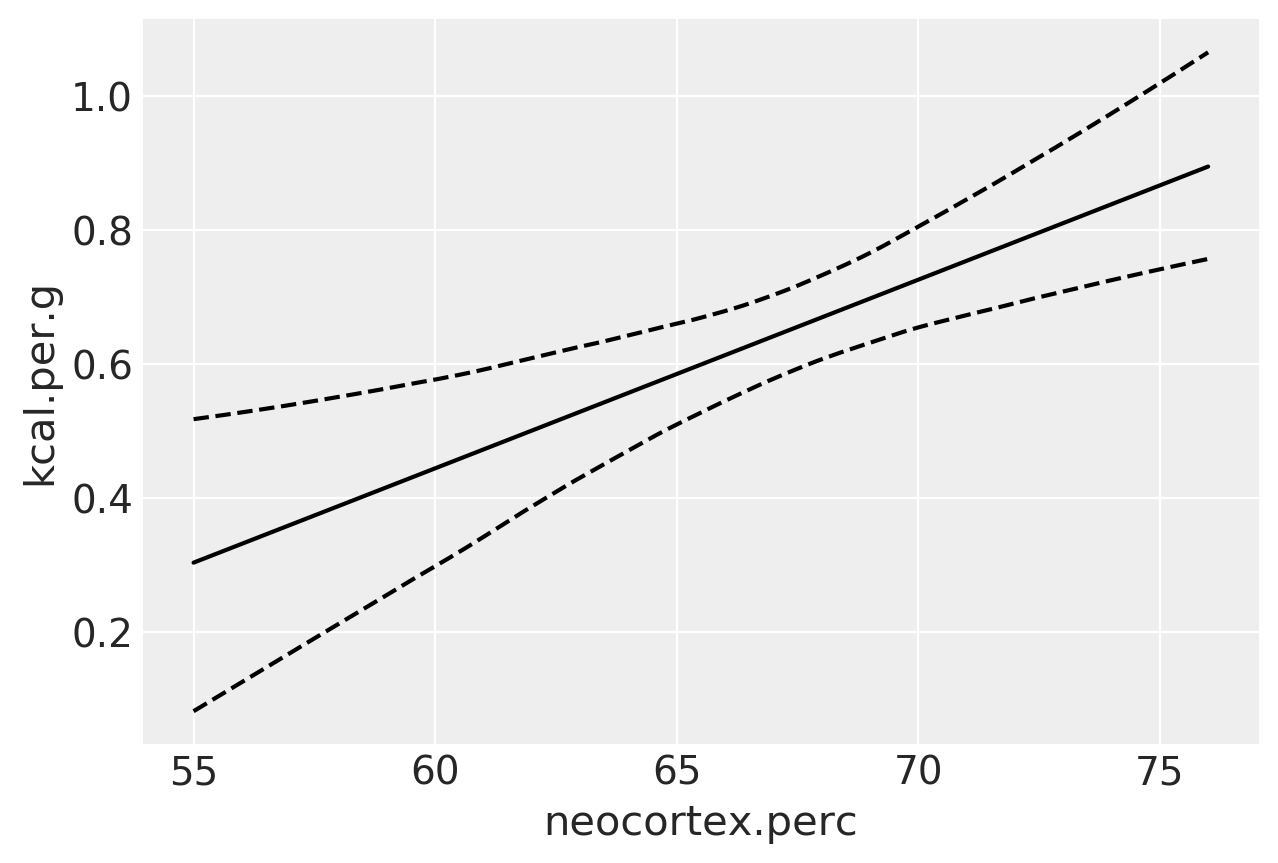

In [37]:
seq = np.linspace(55, 76, 50)
mu_pred = (
    trace_5_7["a"]
    + trace_5_7["bn"][:, 0] * seq[:, None]
    + trace_5_7["bn"][:, 1] * dcc["log_mass"].mean()
)

plt.plot(seq, mu_pred.mean(1), "k")
az.plot_hpd(
    seq,
    mu_pred.T,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"alpha": 1, "color": "k", "ls": "--"},
)

plt.xlabel("neocortex.perc")
plt.ylabel("kcal.per.g");

#### Code 5.28

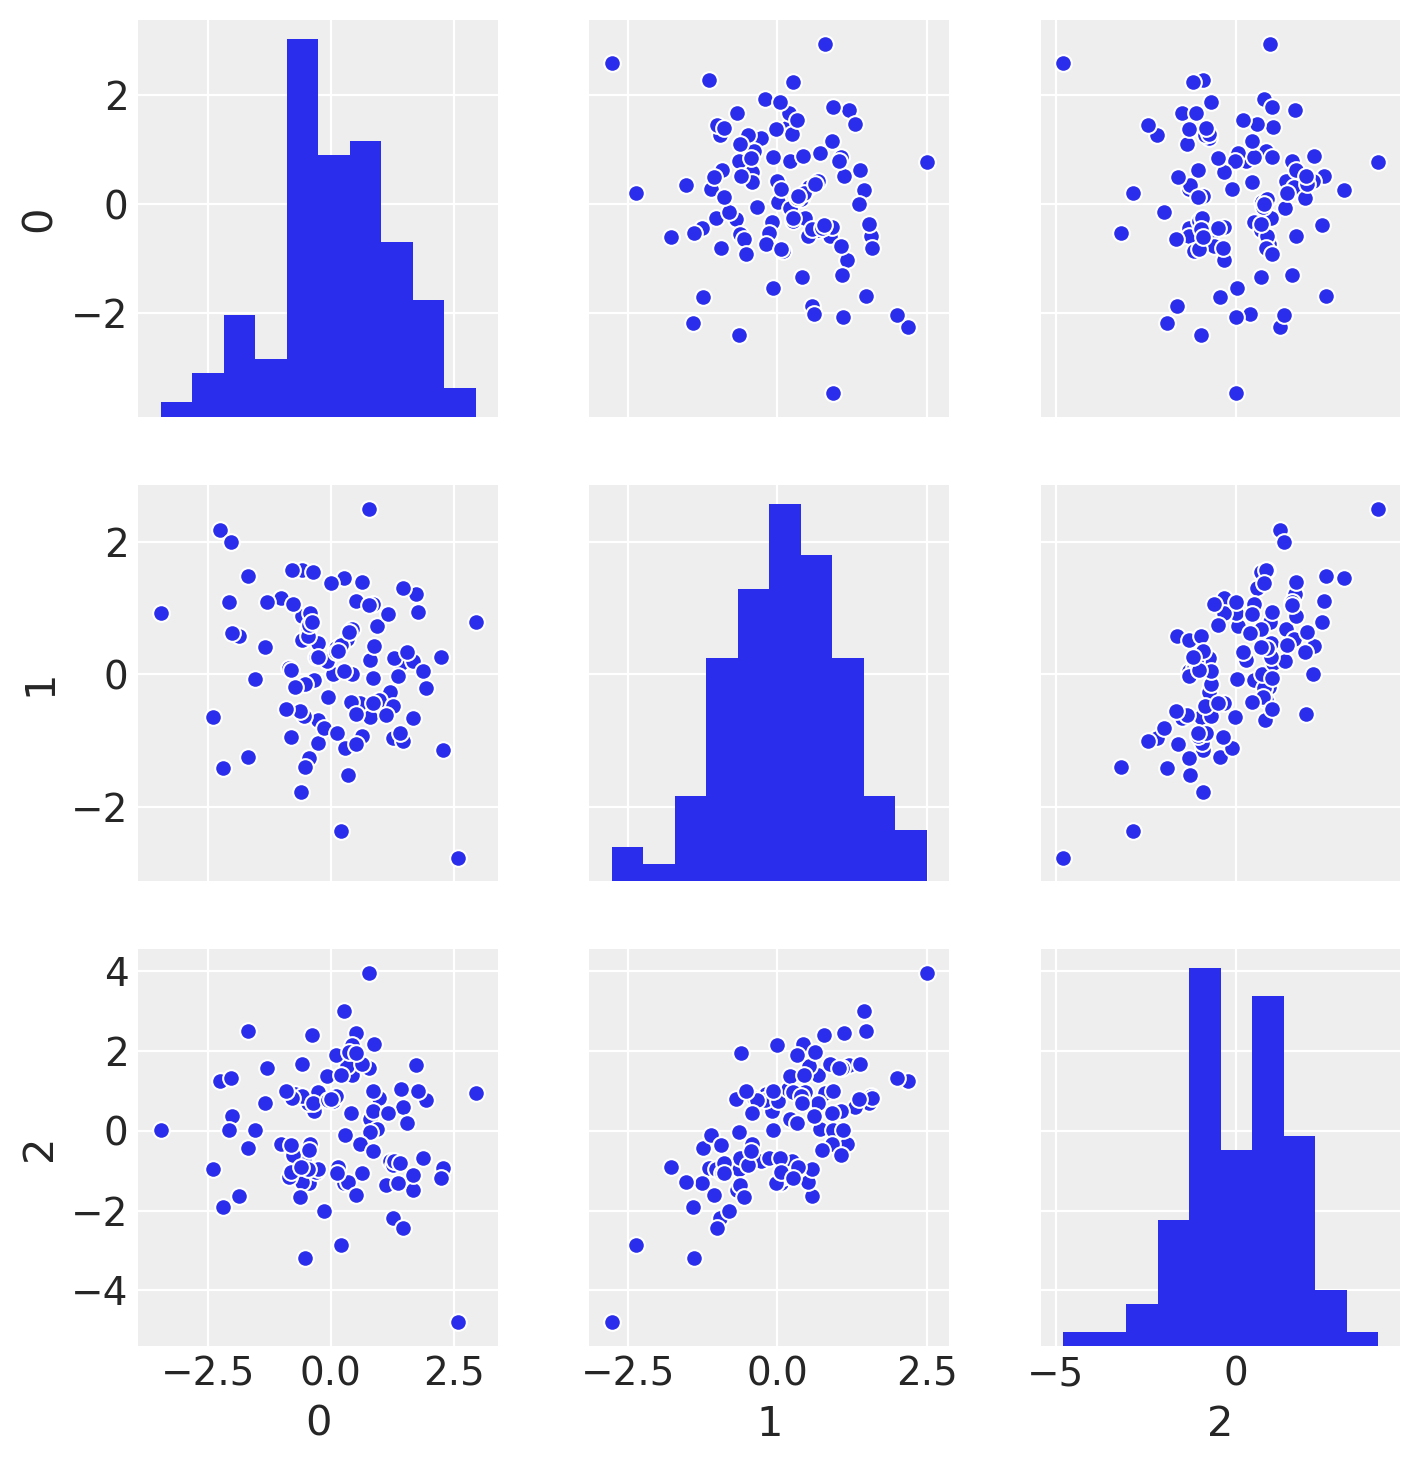

In [38]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho * x_pos, (1 - rho ** 2) ** 0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [39]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5)
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

#### Code 5.30

In [40]:
with pm.Model() as m5_8:
    a = pm.Normal("a", mu=10, sd=100)
    bl = pm.Normal("bl", mu=2, sd=10)
    br = pm.Normal("br", mu=2, sd=10)
    mu = pm.Deterministic("mu", a + bl * leg_left + br * leg_right)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    height_p = pm.Normal("height_p", mu=mu, sd=sigma, observed=height)

    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:16<00:00, 13.12draws/s]


mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      5.572  0.519      0.014    0.010     4.755      6.400    1355.0   
bl     0.486  4.359      0.156    0.117    -6.876      7.181     781.0   
br     0.181  4.353      0.156    0.120    -6.514      7.509     780.0   
sigma  1.472  0.108      0.003    0.002     1.302      1.634    1067.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a      1350.0    1349.0    1062.0    1.0  
bl      693.0     795.0     686.0    1.0  
br      656.0     794.0     686.0    1.0  
sigma  1049.0    1102.0     880.0    1.0

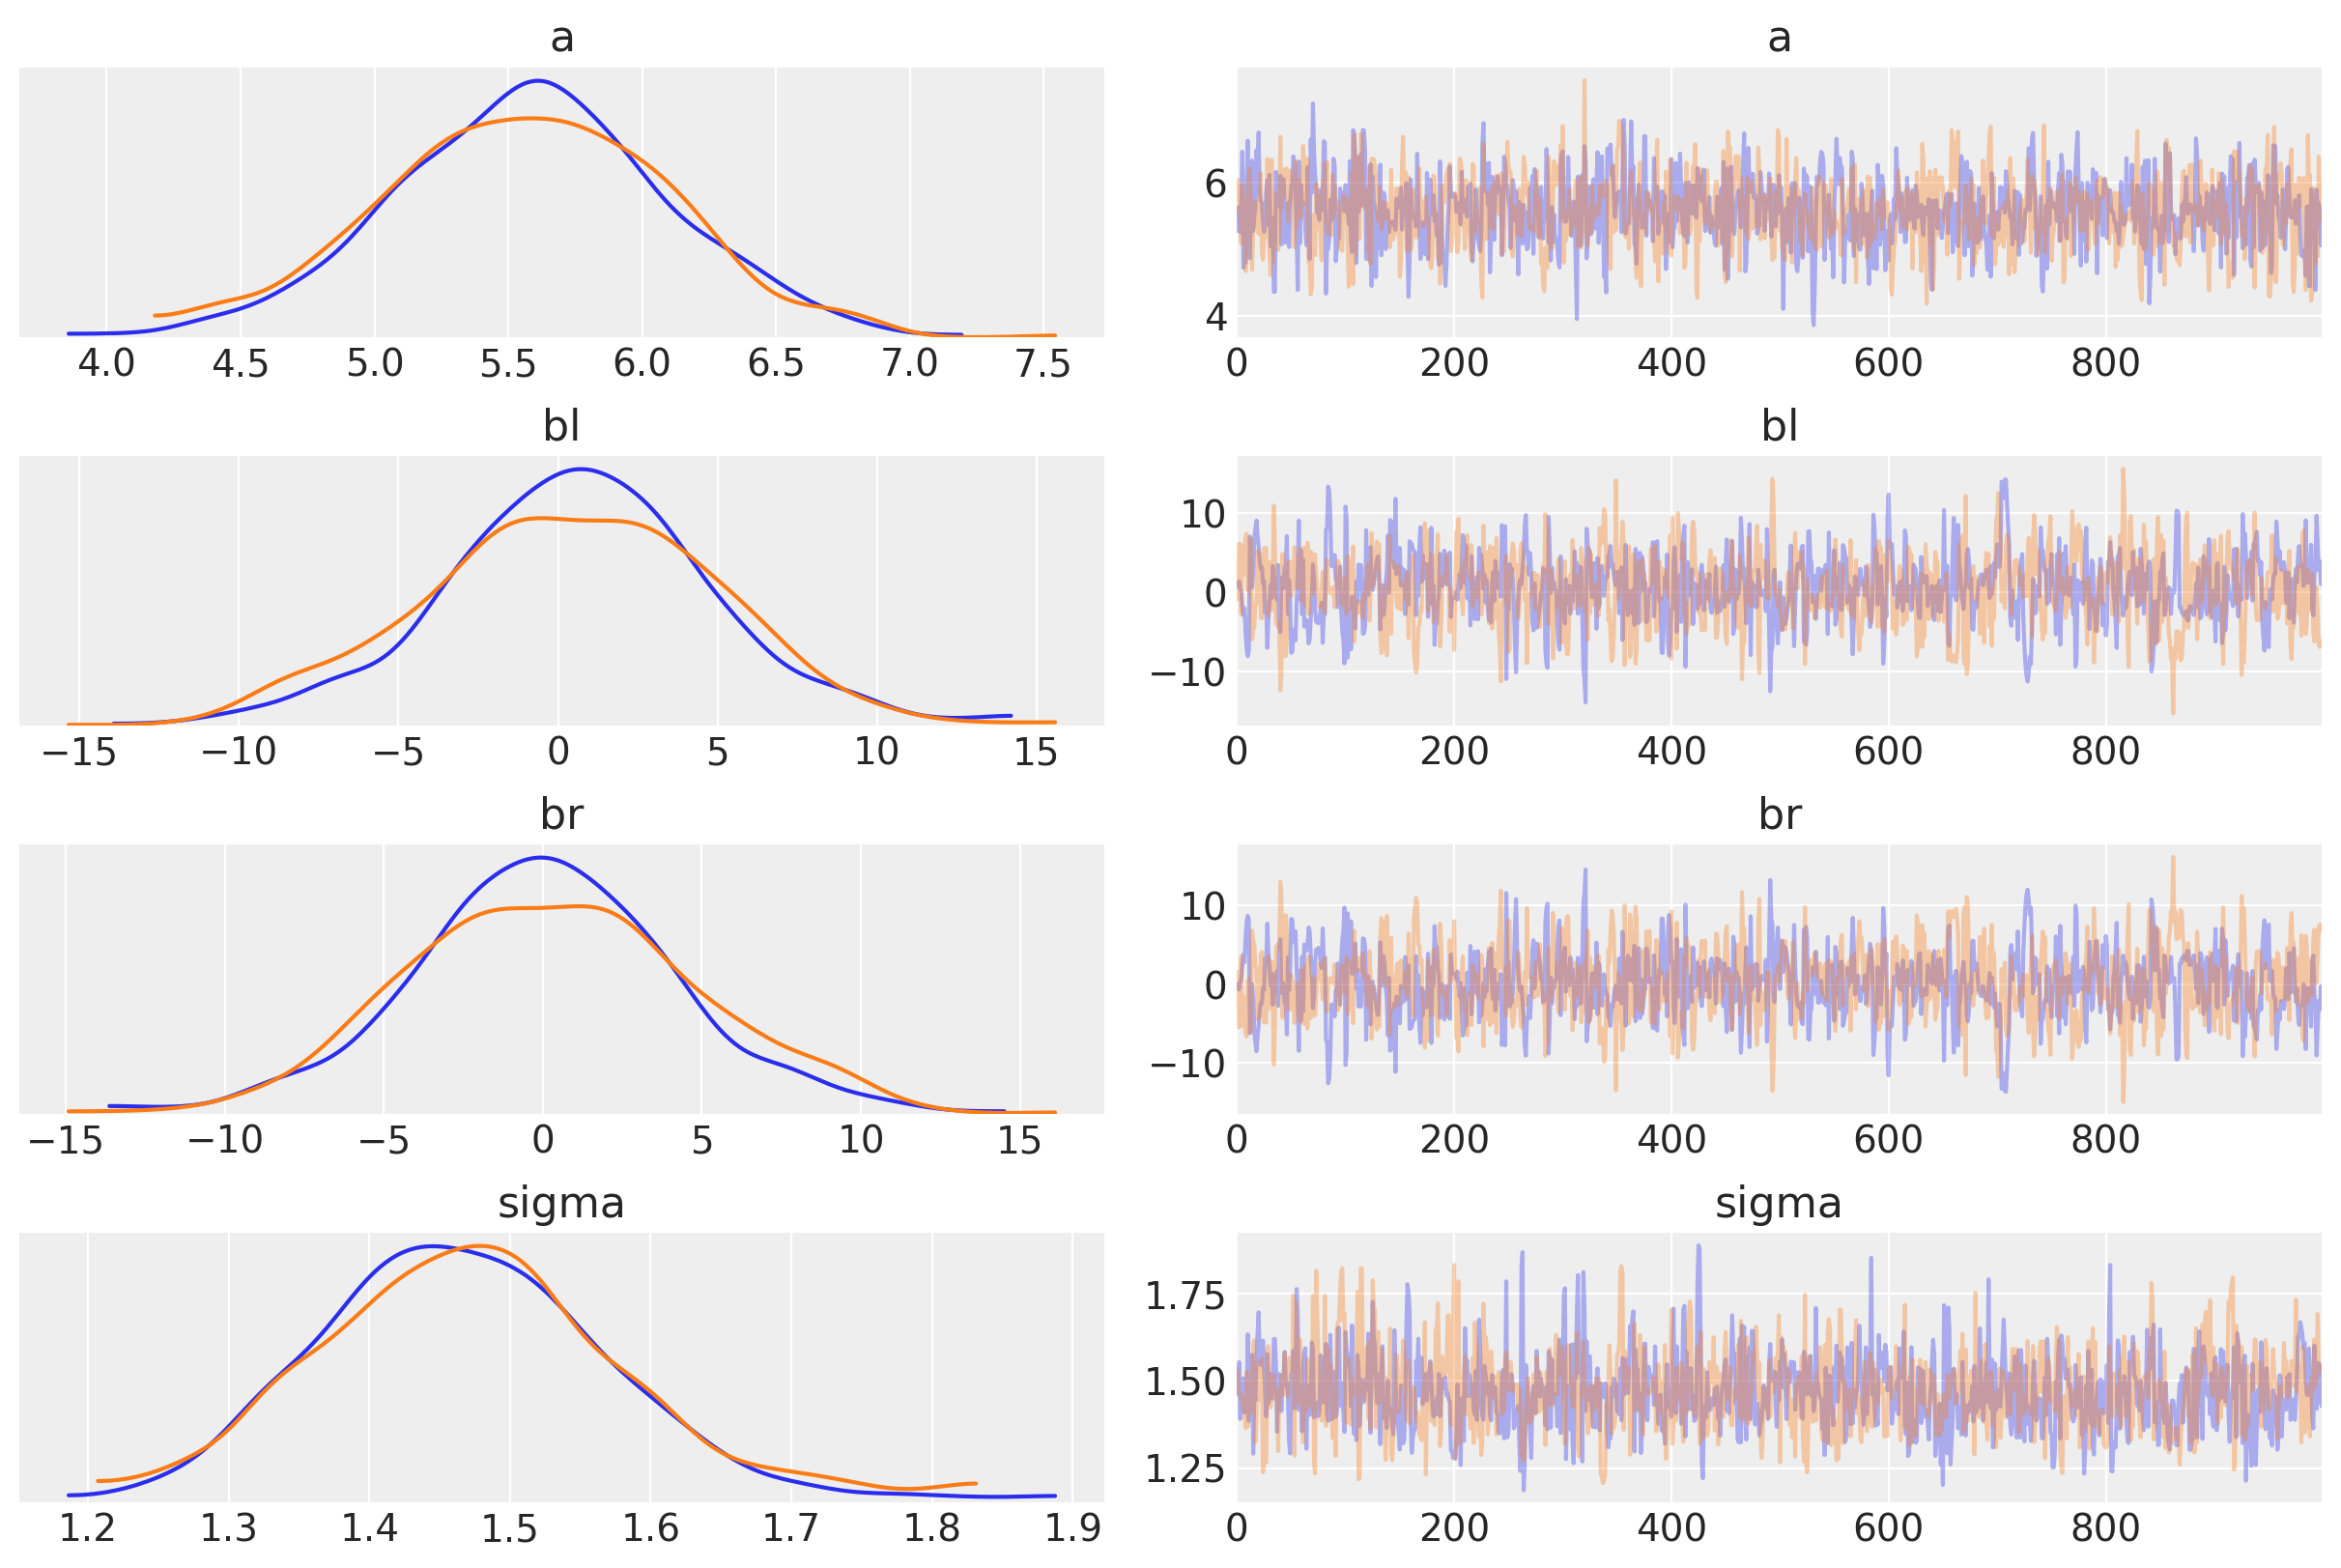

In [41]:
az.plot_trace(trace_5_8, varnames)
az.summary(trace_5_8, varnames, credible_interval=0.89).round(3)

#### Code 5.31

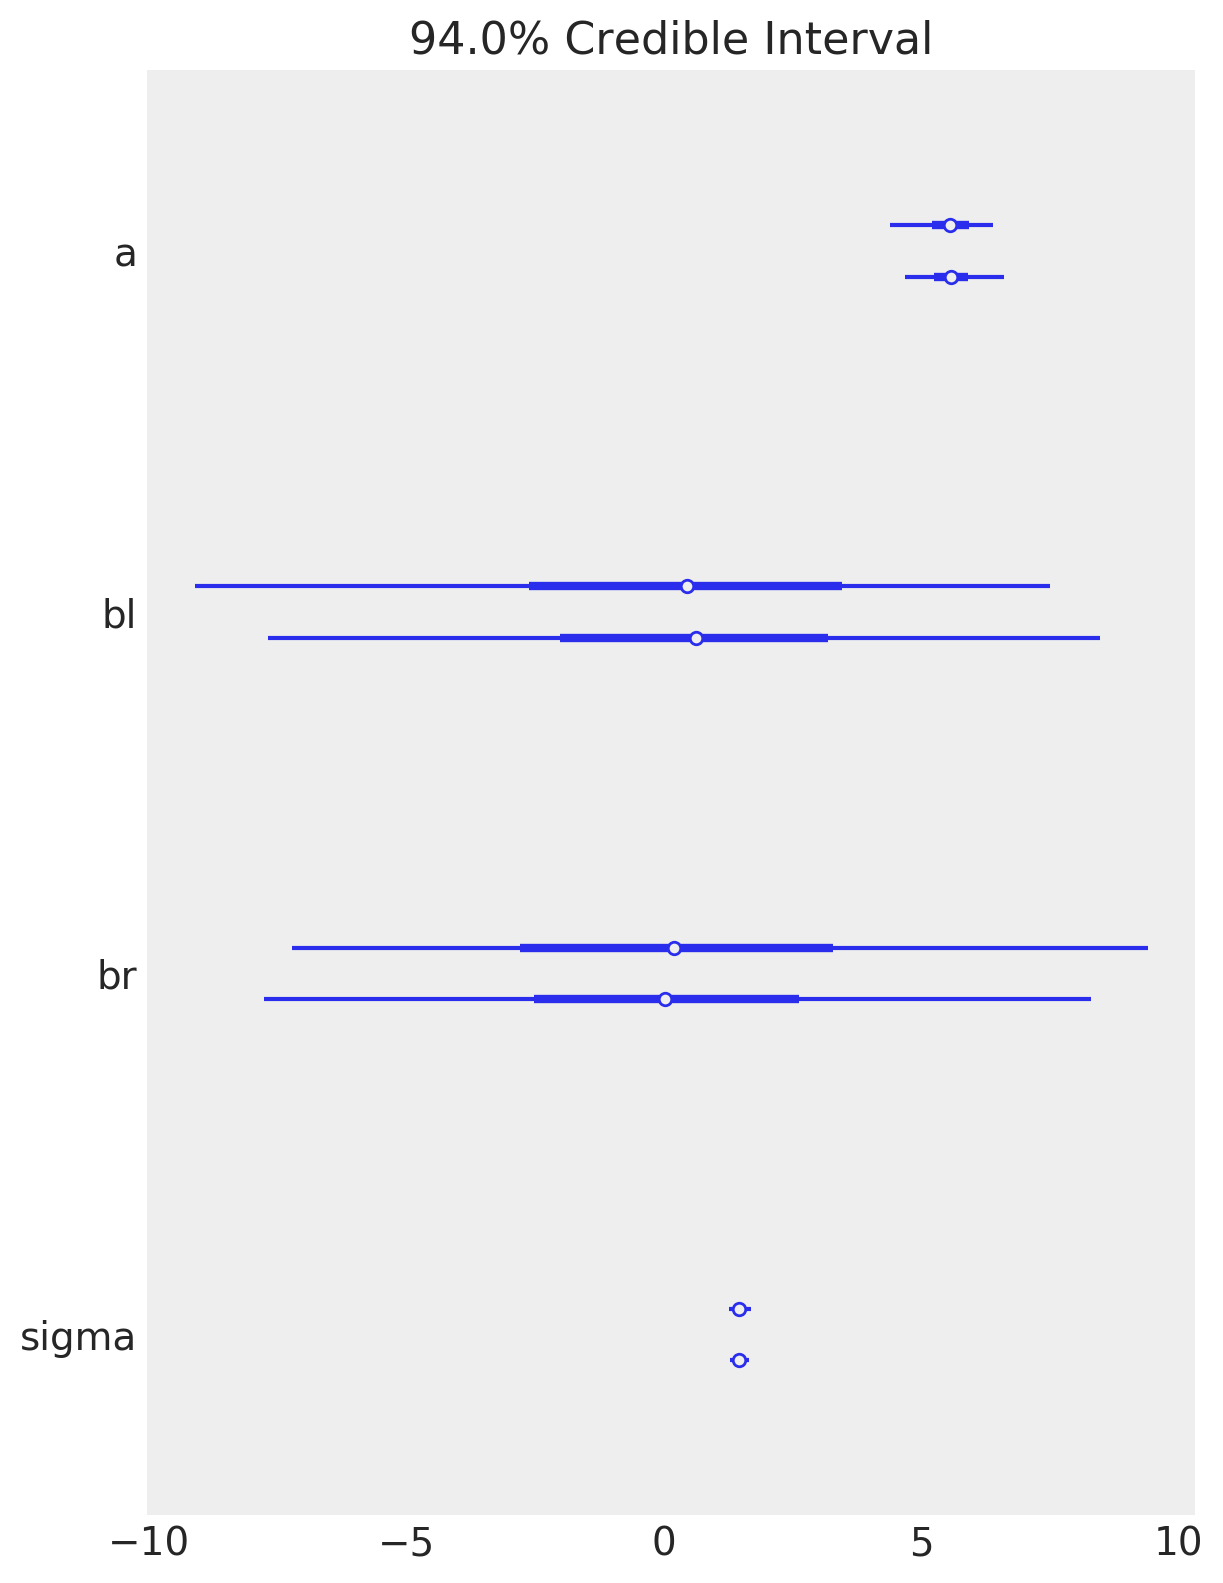

In [42]:
az.plot_forest(trace_5_8, var_names=varnames);

#### Code 5.32

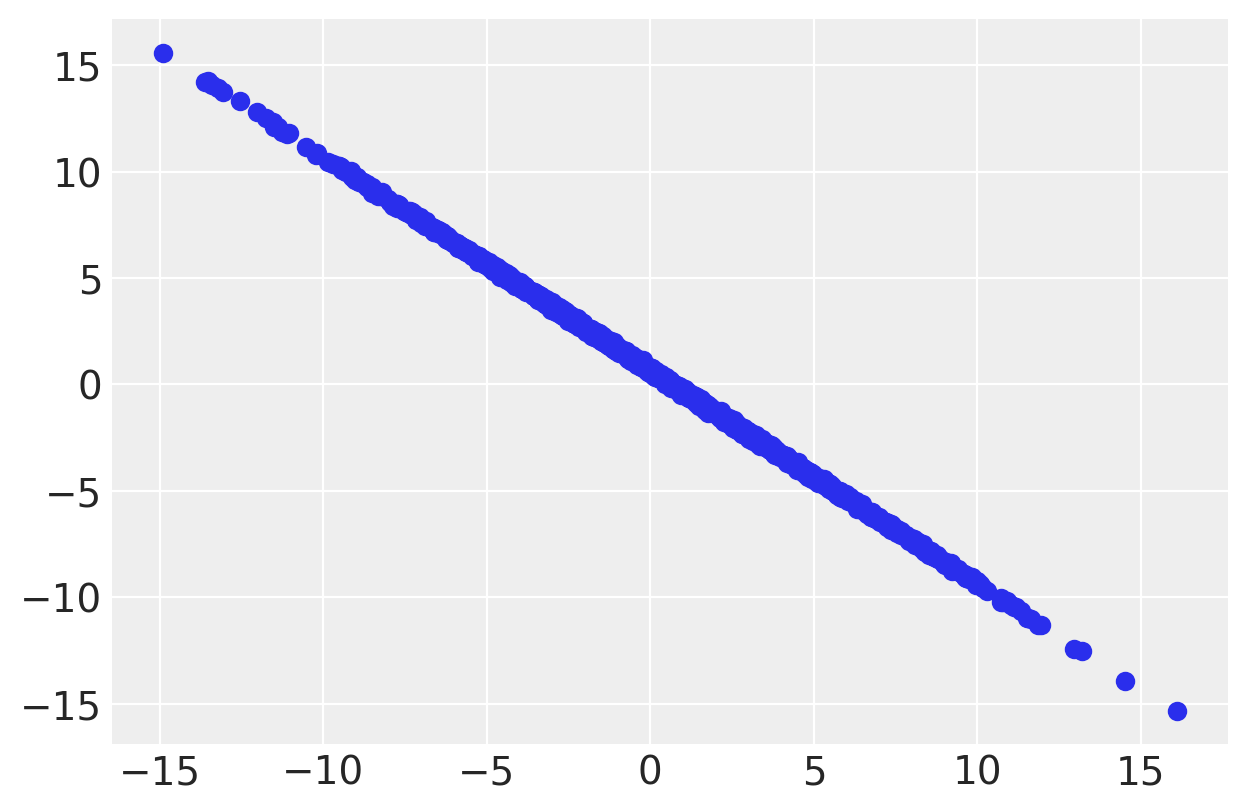

In [43]:
plt.scatter(trace_5_8["br"], trace_5_8["bl"]);

#### Code 5.33

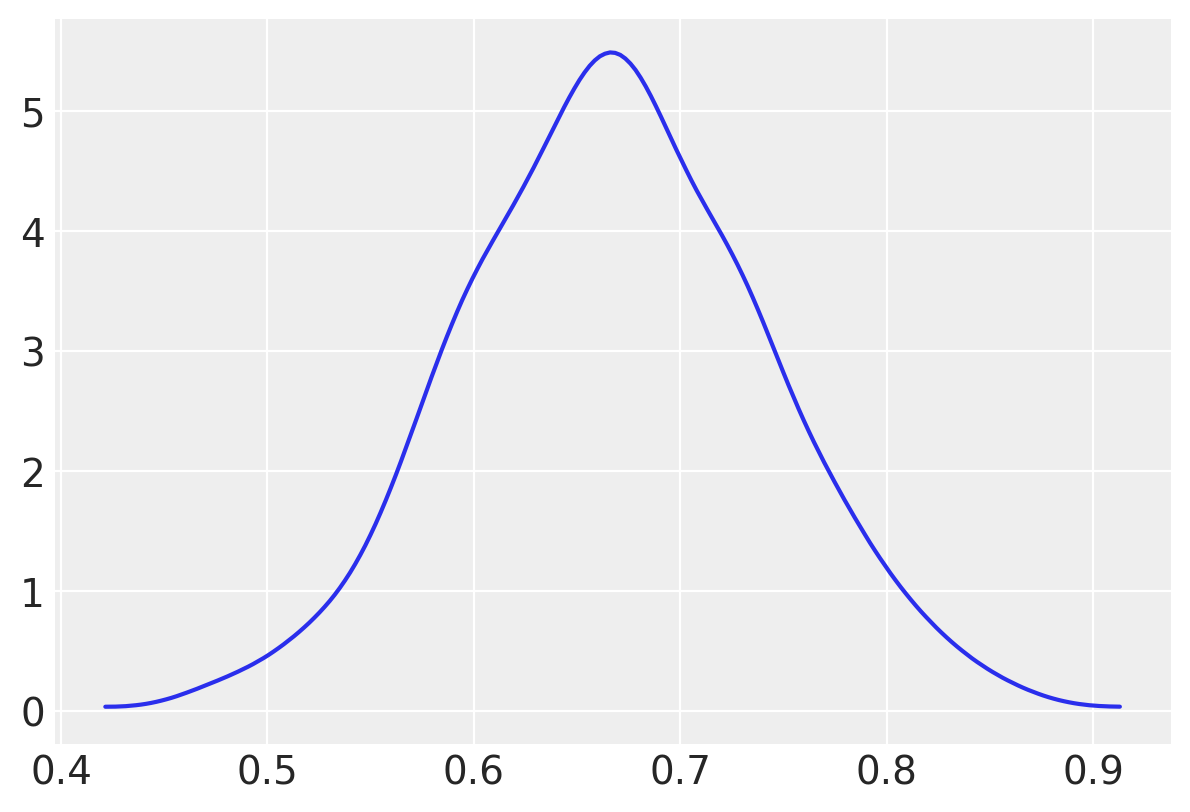

In [44]:
sum_blbr = trace_5_8["br"] + trace_5_8["bl"]
az.plot_kde(sum_blbr);

#### Code 5.34

In [45]:
with pm.Model() as m5_9:
    a = pm.Normal("a", mu=10, sd=100)
    bl = pm.Normal("bl", mu=2, sd=10)
    mu = pm.Deterministic("mu", a + bl * leg_left)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 767.05draws/s]
The acceptance probability does not match the target. It is 0.7154755307843844, but should be close to 0.8. Try to increase the number of tuning steps.


In [46]:
# pm.traceplot(trace_5_9, varnames)
az.summary(trace_5_9, varnames, credible_interval=0.11).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_44.5%  hpd_55.5%  ess_mean  \
a      5.571  0.521      0.020    0.014      5.573      5.714     707.0   
bl     0.667  0.073      0.003    0.002      0.660      0.678     685.0   
sigma  1.471  0.105      0.003    0.002      1.468      1.492    1041.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       687.0     707.0     865.0    1.0  
bl      685.0     683.0     874.0    1.0  
sigma  1041.0    1034.0     849.0    1.0

#### Code 5.35

In [47]:
milk = pd.read_csv("Data/milk.csv", sep=";")
milk.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

#### Code 5.36

In [48]:
with pm.Model() as m5_10:
    a = pm.Normal("a", mu=0.6, sd=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + bf * milk["perc.fat"])
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    kcalperg = pm.Normal("kcal.per.g", mu=mu, sd=sigma, observed=milk["kcal.per.g"])
    trace_5_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 440.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [49]:
az.summary(trace_5_10, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      0.298  0.040      0.002    0.001     0.238      0.362     570.0   
bf     0.010  0.001      0.000    0.000     0.008      0.012     538.0   
sigma  0.080  0.012      0.000    0.000     0.062      0.098     982.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       531.0     560.0     566.0   1.01  
bf      538.0     529.0     640.0   1.01  
sigma   951.0    1033.0     946.0   1.00

In [50]:
with pm.Model() as m5_11:
    a = pm.Normal("a", mu=0.6, sd=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + bl * milk["perc.lactose"])
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    kcalperg = pm.Normal("kcal.per.g", mu=mu, sd=sigma, observed=milk["kcal.per.g"])
    trace_5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 444.87draws/s]


In [51]:
az.summary(trace_5_11, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      1.168  0.047      0.002    0.001     1.090      1.242     795.0   
bl    -0.011  0.001      0.000    0.000    -0.012     -0.009     819.0   
sigma  0.067  0.010      0.000    0.000     0.052      0.083     873.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       795.0     796.0     758.0    1.0  
bl      819.0     823.0     871.0    1.0  
sigma   863.0     874.0     734.0    1.0

#### Code 5.37

In [52]:
with pm.Model() as m5_12:
    a = pm.Normal("a", mu=0.6, sd=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    bl = pm.Normal("bl", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + bf * milk["perc.fat"] + bl * milk["perc.lactose"])
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    kcalperg = pm.Normal("kcal.per.g", mu=mu, sd=sigma, observed=milk["kcal.per.g"])
    trace_5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, bf, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:21<00:00, 186.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [53]:
az.summary(trace_5_12, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      1.019  0.226      0.011    0.008     0.668      1.363     394.0   
bf     0.002  0.003      0.000    0.000    -0.002      0.006     408.0   
bl    -0.009  0.003      0.000    0.000    -0.013     -0.004     403.0   
sigma  0.068  0.011      0.000    0.000     0.052      0.083     595.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       371.0     405.0     506.0    1.0  
bf      408.0     415.0     524.0    1.0  
bl      374.0     418.0     523.0    1.0  
sigma   595.0     582.0     606.0    1.0

#### Code 5.38

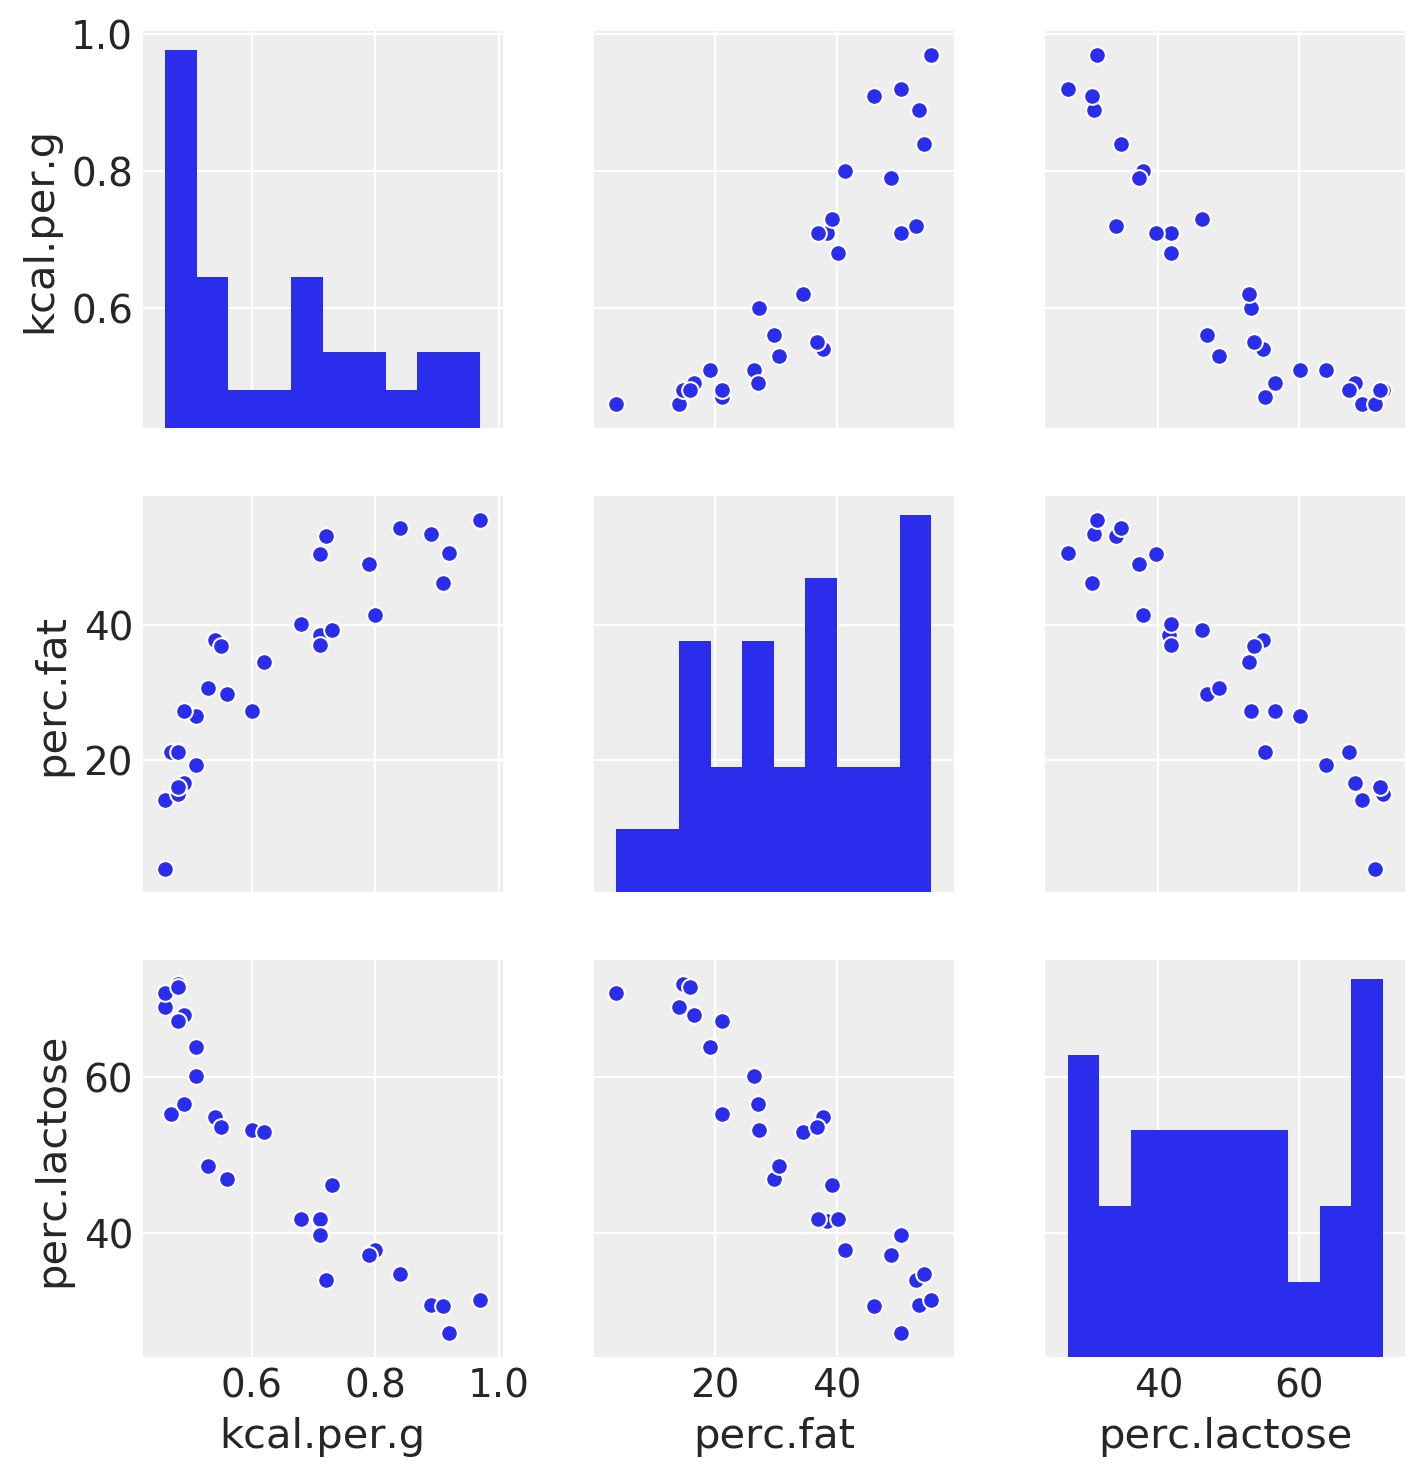

In [54]:
df = milk[["kcal.per.g", "perc.fat", "perc.lactose"]]
sns.pairplot(df);

#### Code 5.39

In [55]:
milk.corr()["perc.fat"]["perc.lactose"]

-0.9416373456839282

#### Code 5.40

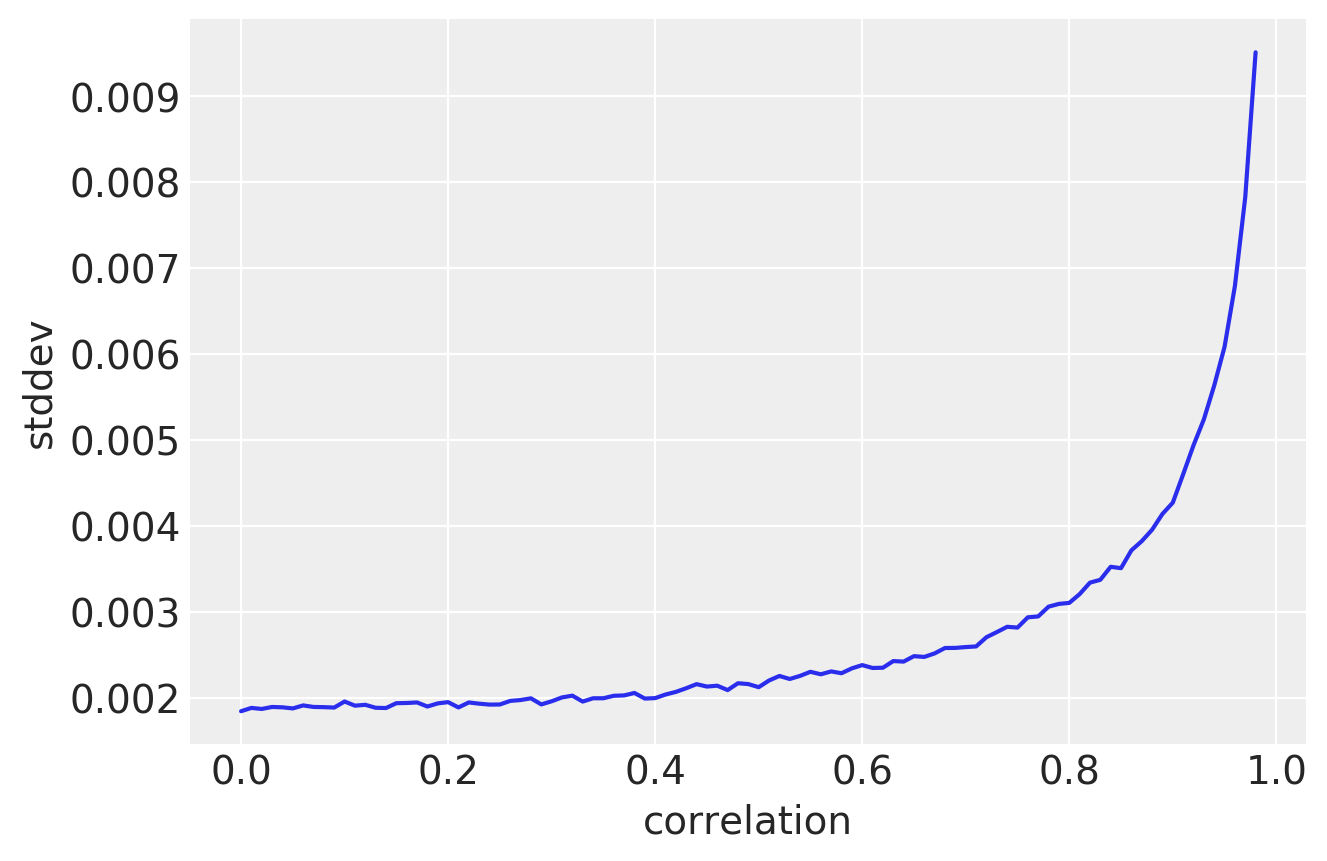

In [56]:
def simcoll(r=0.9):
    milk["x"] = stats.norm.rvs(
        size=len(milk),
        loc=r * milk["perc.fat"],
        scale=np.sqrt((1 - r ** 2) * milk["perc.fat"].var()),
    )
    X = np.column_stack((milk["perc.fat"], milk["x"]))
    m = smf.OLS(milk["kcal.per.g"], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1]) ** 0.5


def repsimcoll(r=0.9, N=100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)


lista = []
for i in np.arange(start=0, stop=0.99, step=0.01):
    lista.append(repsimcoll(r=i, N=100))

plt.plot(np.arange(start=0, stop=0.99, step=0.01), lista)
plt.xlabel("correlation", fontsize=14)
plt.ylabel("stddev", fontsize=14);

#### Code 5.41

In [57]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size=N, loc=10, scale=2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N / 2] * 2)
fungus = np.random.binomial(n=1, p=(0.5 - treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size=N, loc=5 - 3 * fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({"h0": h0, "h1": h1, "Treatment": treatment, "Fungus": fungus})

#### Code 5.42

In [58]:
with pm.Model() as m5_13:
    a = pm.Normal("a", mu=0, sd=100)
    bh = pm.Normal("bh", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bf = pm.Normal("bf", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"].get_values())
    trace_5_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, bh, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:13<00:00, 306.71draws/s]


In [59]:
az.summary(trace_5_13, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      4.045  0.513      0.017    0.012     3.221      4.841     883.0   
bh     1.083  0.048      0.002    0.001     0.999      1.154     934.0   
bt     0.049  0.211      0.006    0.005    -0.267      0.401    1470.0   
bf    -3.050  0.231      0.006    0.004    -3.407     -2.689    1660.0   
sigma  0.937  0.068      0.002    0.001     0.833      1.044    1428.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       883.0     886.0    1043.0    1.0  
bh      934.0     939.0    1035.0    1.0  
bt     1092.0    1471.0    1369.0    1.0  
bf     1660.0    1671.0    1248.0    1.0  
sigma  1422.0    1429.0    1389.0    1.0

#### Code 5.43

In [60]:
with pm.Model() as m5_14:
    a = pm.Normal("a", mu=0, sd=100)
    bh = pm.Normal("bh", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bh * h0 + bt * treatment)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, bh, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 511.60draws/s]


In [61]:
az.summary(trace_5_14, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      3.073  0.901      0.032    0.023     1.637      4.428     778.0   
bh     1.017  0.086      0.003    0.002     0.880      1.150     761.0   
bt     1.450  0.316      0.010    0.007     0.968      1.971    1067.0   
sigma  1.568  0.118      0.003    0.002     1.362      1.733    1156.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       763.0     781.0     792.0    1.0  
bh      761.0     764.0     809.0    1.0  
bt      989.0    1084.0     795.0    1.0  
sigma  1152.0    1150.0    1052.0    1.0

#### Code 5.44

In [62]:
d = pd.read_csv("Data/Howell1.csv", sep=";")
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 5.45

In [63]:
with pm.Model() as m5_15:
    a = pm.Normal("a", mu=178, sd=100)
    bm = pm.Normal("bm", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bm * d["male"])
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1265.34draws/s]


In [64]:
az.summary(trace_5_15, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      134.844  1.552      0.051    0.036   132.448    137.329     940.0   
bm       7.258  2.295      0.073    0.052     3.690     10.955     995.0   
sigma   27.429  0.859      0.020    0.014    26.159     28.876    1886.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       939.0     939.0    1318.0    1.0  
bm      979.0     994.0    1296.0    1.0  
sigma  1882.0    1897.0    1492.0    1.0

#### Code 5.46

In [65]:
mu.male = trace_5_15["a"] + trace_5_15["bm"]
pm.hpd(mu.male)

array([138.79972772, 145.21039429])

#### Code 5.47

In [66]:
with pm.Model() as m5_15b:
    af = pm.Normal("af", mu=178, sd=100)
    am = pm.Normal("am", mu=178, sd=100)
    mu = pm.Deterministic("mu", af * (1 - d["male"]) + am * d["male"])
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, am, af]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1685.11draws/s]


#### Code 5.48

In [67]:
d = pd.read_csv("Data/milk.csv", sep=";")
d = d.drop_duplicates()

#### Code 5.49

In [68]:
d["clade.NWM"] = np.where(d["clade"] == "New World Monkey", 1, 0)
d["clade.NWM"].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

#### Code 5.50

In [69]:
d["clade.OWM"] = np.where(d["clade"] == "Old World Monkey", 1, 0)
d["clade.S"] = np.where(d["clade"] == "Strepsirrhine", 1, 0)

#### Code 5.51

In [70]:
with pm.Model() as m5_16:
    a = pm.Normal("a", mu=0.6, sd=10)
    b_NWM = pm.Normal("b_NWM", mu=0, sd=1)
    b_OWM = pm.Normal("b_OWM", mu=0, sd=1)
    b_S = pm.Normal("b_S", mu=0, sd=1)
    mu = pm.Deterministic(
        "mu", a + b_NWM * d["clade.NWM"] + b_OWM * d["clade.OWM"] + b_S * d["clade.S"]
    )

    # instead of adding this as a deterministic when running the model
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16[a] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic("mu_ape", a + 0)
    mu_NWM = pm.Deterministic("mu_NWM", a + b_NWM)
    mu_OWM = pm.Deterministic("mu_OWM", a + b_OWM)
    mu_S = pm.Deterministic("mu_S", a + b_S)

    sigma = pm.Uniform("sigma", lower=0, upper=10)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_S, b_OWM, b_NWM, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 929.16draws/s] 


In [71]:
varnames = ["a", "b_NWM", "b_OWM", "b_S", "sigma"]
az.summary(trace_5_16, varnames, credible_interval=0.89).round(3)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a      0.544  0.042      0.001    0.001     0.474      0.608     945.0   
b_NWM  0.171  0.061      0.002    0.001     0.083      0.277    1078.0   
b_OWM  0.244  0.064      0.002    0.001     0.139      0.343    1119.0   
b_S   -0.036  0.071      0.002    0.002    -0.149      0.072    1234.0   
sigma  0.130  0.020      0.001    0.000     0.100      0.160    1244.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       945.0     946.0    1011.0    1.0  
b_NWM  1053.0    1080.0    1166.0    1.0  
b_OWM  1116.0    1121.0    1311.0    1.0  
b_S    1046.0    1228.0    1322.0    1.0  
sigma  1244.0    1219.0     864.0    1.0

#### Code 5.52

In [72]:
varnames = ["mu_ape", "mu_NWM", "b_OWM", "b_S"]
az.summary(trace_5_16, varnames, credible_interval=0.89).round(3)[
    ["mean", "sd", "hpd_5.5%", "hpd_94.5%"]
]

mean     sd  hpd_5.5%  hpd_94.5%
mu_ape  0.544  0.042     0.474      0.608
mu_NWM  0.716  0.045     0.648      0.790
b_OWM   0.244  0.064     0.139      0.343
b_S    -0.036  0.071    -0.149      0.072

#### Code 5.53

In [73]:
diff_NMW_OWM = trace_5_16["mu_NWM"] - trace_5_16["mu_OWM"]
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(
    diff_NMW_OWM, 97.5
)

(-0.21097707286920986, -0.0720665483683684, 0.06629452593247048)

#### Code 5.54

In [74]:
z = pd.Categorical(d["clade"])
d["clade_id"] = z.codes

#### Code 5.55

In [75]:
with pm.Model() as m5_16_alt:
    a = pm.Normal("a", mu=0.6, sd=10, shape=len(d["clade_id"].unique()))
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=a[d["clade_id"].values], sd=sigma, observed=d["kcal.per.g"]
    )
    trace_5_16_alt = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1183.09draws/s]


In [76]:
varnames = ["a", "sigma"]
az.summary(trace_5_16_alt, varnames, credible_interval=0.89)

mean     sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  \
a[0]   0.544  0.043      0.001    0.001     0.479      0.616    2324.0   
a[1]   0.715  0.044      0.001    0.001     0.645      0.784    2219.0   
a[2]   0.789  0.050      0.001    0.001     0.709      0.865    2304.0   
a[3]   0.510  0.060      0.001    0.001     0.412      0.602    2239.0   
sigma  0.130  0.019      0.000    0.000     0.097      0.155    1862.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a[0]   2324.0    2343.0    1565.0    1.0  
a[1]   2219.0    2207.0    1545.0    1.0  
a[2]   2301.0    2324.0    1715.0    1.0  
a[3]   2186.0    2246.0    1415.0    1.0  
sigma  1813.0    1898.0    1543.0    1.0

The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [77]:
data = pd.read_csv("Data/cars.csv", sep=",")
pm.GLM.from_formula("dist ~ speed", data=data)

In [78]:
import platform
import sys

import IPython
import matplotlib
import scipy

print(
    """This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(
        sys.version[:5],
        IPython.__version__,
        pm.__version__,
        az.__version__,
        np.__version__,
        scipy.__version__,
        matplotlib.__version__,
    )
)

This notebook was created using:
Python 3.7.1
IPython 6.2.1
PyMC3 3.7.rc1
ArviZ 0.4.0
NumPy 1.15.4
SciPy 1.1.0
Matplotlib 3.0.2

